# Problem Statement

In [1]:
import numpy as np
import pandas as pd
import time
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,StratifiedShuffleSplit,cross_val_score,GridSearchCV
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier,GradientBoostingRegressor,GradientBoostingClassifier 
from sklearn.ensemble import GradientBoostingClassifier
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from sklearn.metrics import r2_score,confusion_matrix,f1_score
from sklearn.linear_model import Ridge
from matplotlib.colors import ListedColormap
from collections import Counter
from sklearn.metrics import mean_squared_error as mse
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_graphviz
import scipy.optimize as opt
from multiprocessing import Pool
import concurrent.futures as cf
import random
import matplotlib as mpl
import dill
from IPython.display import Image
from sklearn.metrics import make_scorer
from sklearn.linear_model import Ridge, RidgeClassifier, LogisticRegression
from sklearn.model_selection import cross_validate
import os

# Reading Central & Satellite data

Read data from the raw text files once using pandas dataframe. This is time consuming and takes about 10 minutes. Then save the dataframe using dill to avoid reading the raw data over and over again. Opening a dill file takes about 1-2 minutes.  

In [ ]:
start = time.time()
cent_data = pd.read_csv('/Users/saurabh/Google_Drive/Assembly_Bias/central/pd-cenlgMh_34col_1.txt', sep=",")
str1 = "/Users/saurabh/Google_Drive/Assembly_Bias/central/pd-cenlgMh_34col_"
for i in range(2,26):
    file2 = str1 + str(i) + '.txt'
    data2 = pd.read_csv(file2, sep=",")
    cent_data = cent_data.append(data2,ignore_index = True)
    print(i, end=' ')
end = time.time()
print('time = ', '{:1.1f}'.format((end - start)/60.),'minutes')

In [5]:
#dill.dump(cent_data, open('/Users/saurabh/Google_Drive/Assembly_Bias/central/cent_data.pkd', 'wb'))

Download .pkd.zip data from AWS S3 once to your local directory.

In [21]:
path = '/Users/saurabh/Google_Drive/Assembly_Bias/central/'
!wget --directory-prefix=$path -nc https://assemblybias.s3.us-east-2.amazonaws.com/central/cent_data.pkd.zip

--2021-01-01 14:06:14--  https://assemblybias.s3.us-east-2.amazonaws.com/central/cent_data.pkd.zip
Resolving assemblybias.s3.us-east-2.amazonaws.com... 52.219.84.216
Connecting to assemblybias.s3.us-east-2.amazonaws.com|52.219.84.216|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1120387007 (1.0G) [application/zip]
Saving to: '/Users/saurabh/Google_Drive/Assembly_Bias/central/cent_data.pkd.zip'

cent_data.pkd.zip   100%[===================>]   1.04G  2.14MB/s    in 9m 1s   

2021-01-01 14:15:15 (1.97 MB/s) - '/Users/saurabh/Google_Drive/Assembly_Bias/central/cent_data.pkd.zip' saved [1120387007/1120387007]



In [25]:
!unzip -u $path/cent_data.pkd.zip -d $path

Archive:  /Users/saurabh/Google_Drive/Assembly_Bias/central//cent_data.pkd.zip
  inflating: /Users/saurabh/Google_Drive/Assembly_Bias/central/cent_data.pkd  


In [2]:
path = '/Users/saurabh/Google_Drive/Assembly_Bias/central/'
cent_data = dill.load(open(path+'cent_data.pkd', 'rb'))

In [3]:
sat_data = pd.read_csv('/Users/saurabh/Google_Drive/Assembly_Bias/satellite/new_satlgMh9col_1.txt', sep=",", header=None)
str1 = "/Users/saurabh/Google_Drive/Assembly_Bias/satellite/new_satlgMh9col_"
for i in range(2,26):
    file2 = str1 + str(i) + '.txt'
    data2 = pd.read_csv(file2, sep=",", header=None)
    sat_data = sat_data.append(data2,ignore_index = True)
    print(i, end=' ')

2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 

In [4]:
#dill.dump(sat_data, open('/Users/saurabh/Google_Drive/Assembly_Bias/satellite/sat_data.pkd', 'wb'))

In [31]:
path = '/Users/saurabh/Google_Drive/Assembly_Bias/satellite/'
!wget --directory-prefix=$path -nc https://assemblybias.s3.us-east-2.amazonaws.com/satellite/sat_data.pkd.zip
!unzip -u $path/sat_data.pkd.zip -d $path
sat_data = dill.load(open(path+'sat_data.pkd', 'rb'))

--2021-01-02 09:24:58--  https://assemblybias.s3.us-east-2.amazonaws.com/satellite/sat_data.pkd.zip
Resolving assemblybias.s3.us-east-2.amazonaws.com... 52.219.80.200
Connecting to assemblybias.s3.us-east-2.amazonaws.com|52.219.80.200|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 311922931 (297M) [application/zip]
Saving to: '/Users/saurabh/Google_Drive/Assembly_Bias/satellite/sat_data.pkd.zip'

sat_data.pkd.zip    100%[===================>] 297.47M  2.75MB/s    in 2m 5s   

2021-01-02 09:27:03 (2.38 MB/s) - '/Users/saurabh/Google_Drive/Assembly_Bias/satellite/sat_data.pkd.zip' saved [311922931/311922931]

Archive:  /Users/saurabh/Google_Drive/Assembly_Bias/satellite//sat_data.pkd.zip
  inflating: /Users/saurabh/Google_Drive/Assembly_Bias/satellite/sat_data.pkd  


In [3]:
sat_data = dill.load(open('/Users/saurabh/Google_Drive/Assembly_Bias/satellite/sat_data.pkd', 'rb'))

Downloading from AWS S3, extracting and reading all at once.

## Defining all columns of central and satellites

In [4]:
#cent_data.columns = ['galaxyID','fofCentralId','subHaloID','phkey','con','mvir','vmax','a05','a08','vpeak',
#'zvpeak','macc','smacc','mergnum','z_firstmerg','z_lastmerg','stellarMass','fofID',
#'centralMvir','x','y','z','type','spinX','spinY','spinZ','g1_25','g2_5','g5','g10','alpha']

In [4]:
cent_data['total_spin'] = ((cent_data.spinX)**2 + 
(cent_data.spinY)**2 + (cent_data.spinZ)**2)**(1/2)
cent_data['total_spin'] = cent_data['total_spin']/cent_data['centralMvir'] #Spin/mass

#cent_data['rke_max'] = cent_data['mvir']*(cent_data['vmax']**2)
#cent_data['rke_peak'] = cent_data['mvir']*(cent_data['vpeak']**2)

In [5]:
sat_data.columns = ['galaxyID','fofCentralId','stellarMass','fofID','centralMvir','x','y','z','con']

# Preliminary exploration

### Exploring nature of columns: numeric or non-numeric

In [7]:
cent_data.head().T

,0,1,2,3,4
galaxyID,2.473800e+10,2.135600e+10,1.260700e+10,1.869400e+10,1.492000e+10
fofCentralId,2.473800e+10,2.135600e+10,1.260700e+10,1.869400e+10,1.492000e+10
subHaloID,6.300000e+13,6.300000e+13,6.300000e+13,6.300000e+13,6.300000e+13
phkey,2.170000e+02,4.370000e+02,1.941000e+03,3.179000e+03,3.384000e+03
con,1.111958e+00,1.030689e+00,1.122777e+00,1.399833e+00,1.121780e+00
mvir,1.204919e+00,1.118854e+00,1.118854e+00,1.204919e+00,1.204919e+00
vmax,4.145605e+01,3.748857e+01,4.083801e+01,5.218859e+01,4.182220e+01
a05,6.707600e-01,8.527590e-01,5.934550e-01,5.960430e-01,6.407860e-01
a08,6.952450e-01,8.654040e-01,5.991070e-01,6.099560e-01,6.469700e-01
vpeak,5.878061e+01,4.809463e+01,4.940565e+01,5.502338e+01,5.514201e+01


In [8]:
sat_data.head()

,galaxyID,fofCentralId,stellarMass,fofID,centralMvir,x,y,z,con
0,10022714000024,10022714000000,0.000056,63001000016093,1.118854,0.341687,97.447760,224.98695,0.619767
1,14016663000018,14016663000000,0.000647,63001400015295,1.118854,105.567570,4.216068,240.00592,1.185708
2,33018471000019,33018471000000,0.000874,63003200015601,1.118854,194.013030,173.817210,58.41450,1.110460
3,42019019000012,42019019000000,0.000427,63004100019974,1.118854,205.166170,162.611430,229.33305,1.160042
4,85008109000022,85008109000000,0.000830,63008200018164,1.118854,124.323500,452.953740,247.57027,1.557637


Looking at the first few rows of both central and satellite data reveals all columns are numeric.

### Searching for missing values

In [11]:
cent_data.isnull().sum()

galaxyID        0
fofCentralId    0
subHaloID       0
phkey           0
con             0
mvir            0
vmax            0
a05             0
a08             0
vpeak           0
zvpeak          0
macc            0
smacc           0
mergnum         0
z_firstmerg     0
z_lastmerg      0
stellarMass     0
fofID           0
centralMvir     0
x               0
y               0
z               0
type            0
spinX           0
spinY           0
spinZ           0
g1_25           0
g2_5            0
g5              0
g10             0
alpha           0
class4          0
r10m            0
r10mid          0
total_spin      0
dtype: int64

In [12]:
sat_data.isnull().sum()

galaxyID        0
fofCentralId    0
stellarMass     0
fofID           0
centralMvir     0
x               0
y               0
z               0
con             0
dtype: int64

No missing values found!

# Predicting number of satellites in a halo

We are trying to predict the number of satellites above a threshold mass, $m_{\rm{above}} = 1.42\times 10^{10}~h^{-1}~{M_{\odot}}$,  a dark matter (DM) halo can have if we are given the halo properties. This is a regression (continuous values) problem. 

## Data Preparation
In total, there are ~8.76 million unique halos, also meaning the same number of central galaxies. Total satellite number is 10.4 million.

We begin with separating out all satellites that are above $m_{\rm{above}}$. We then identify the unique halos in this subset. The rest of the halos in the satellite data must have no satellites above $m_{\rm{above}}$. Furthermore, we only keep halos of mass above $10^{10.7}~h^{-1}~{M_{\odot}}$. This reduces the halo sample to 4.6 million. The final satellite count is 505,784.   

In [34]:
sat_data.groupby(['fofID']).head()[['fofID','fofCentralId','galaxyID','stellarMass','centralMvir','x','y','z','con']].tail()

,fofID,fofCentralId,galaxyID,stellarMass,centralMvir,x,y,z,con
10386704,63044900000000,448000101092156,448000101516629,0.076253,214073.12,33.801426,208.17307,448.99402,1.385032
10386705,63044900000000,448000101092156,448000101516669,0.099125,214073.12,29.441757,212.65385,450.37870,0.962558
10386706,63044900000000,448000101092156,448000101516709,0.554519,214073.12,34.426780,213.32250,449.91750,1.160679
10386707,63044900000000,448000101092156,448000101516573,0.297132,214073.12,33.787880,213.66210,449.02722,1.179561
10386708,63044900000000,448000101092156,448000101516524,0.030571,214073.12,31.662570,210.11888,445.08550,1.051285


In [130]:
def index_reset_drop(df):
    """
    Resets row indices, and drops index column from pandas 
    operation.
    df: pandas dataframe
    """
    df = df.reset_index()
    return df.drop(columns=['index'])

In [53]:
# Identifying unique halo IDs that contain atleast 1 satellite with
# m > stellarMass_cut

# sat_data_above is a pd df which contains data from sat_data 
# (entire satellite dataset) with m > stellarMass_cut.

#stellarMass_cut = 3.88 # n = 0.00316
#stellarMass_cut = 1.42 # n = 0.01
stellarMass_cut = 0.185 # n = 0.0316

sat_data_above = sat_data[sat_data['stellarMass'] > stellarMass_cut]
sat_data_above = index_reset_drop(sat_data_above)

# haloID_above contains the fofID (haloID) of sat_data_above
# sat_data_above["fofID"].value_counts() returns 2 columns: fofID and 
# #of satellites as a pandas.core.series.Series in the decreasing order
# of #of sats.
# .index returns the fofIDs column as a pandas.core.indexes.numeric.Int64Index
# .values returns the fofIDs column as a np array

haloID_above = sat_data_above["fofID"].value_counts().index.values

In [54]:
# Identifying halo IDs and corresponding halo properties of halos
# that do not contain any sat with m > stellarMass_cut

# sat_data_below is a pd df which contains data from sat_data 
# (entire satellite dataset) with m < stellarMass_cut.

sat_data_below = sat_data[~sat_data['fofID'].isin(haloID_above)]
sat_data_below = index_reset_drop(sat_data_below)

# halo_below is a pd df that contains halo properties of halos 
# containing no sats with m > stellarMass_cut 

haloID_below = sat_data_below['fofID'].unique()
halo_below = cent_data[cent_data['fofID'].isin(haloID_below)]
halo_below = index_reset_drop(halo_below)

In [55]:
# Identifying halo properties of halos with satellites m > stellarMass_cut

# halo_above is a pd df that contains halo properties of halos 
# containing atleast 1 sat with m > stellarMass_cut

halo_above = cent_data[cent_data['fofID'].isin(haloID_above)]
halo_above = index_reset_drop(halo_above)

# Combining both halo classes

halo_full = halo_above.append(halo_below, ignore_index = True)

In [56]:
# Setting ground truth of halos

# sat_num.to_numpy() gives the values of the 2nd column (# of sats)
# in sat_num

sat_num = sat_data_above['fofID'].value_counts()
sat_num_np = sat_num.to_numpy()

# ground_truth_above contains 2 columns: haloIDs and # of sats

ground_truth_above = pd.DataFrame({'fofID': haloID_above, 
                    'Number of Sats': sat_num_np})

In [57]:
# ground_truth_above_sort contains sat numbers in ascending order
# of halo IDs

ground_truth_above_sort = ground_truth_above.sort_values(by = ['fofID'])
ground_truth_above_sort = index_reset_drop(ground_truth_above_sort)

# halo_above_sort contains halo properties in ascending order
# of halo IDs

halo_above_sort = halo_above.sort_values(by = ['fofID'])
halo_above_sort = index_reset_drop(halo_above_sort)

# Now add another column to halo properties that contains sat numbers

halo_above_sort['Number of Sats'] = ground_truth_above_sort['Number of Sats']
halo_below['Number of Sats'] = 0

halo_full_ID = halo_full['fofID'].unique()
halo_more = cent_data[~cent_data['fofID'].isin(halo_full_ID)]
halo_more = index_reset_drop(halo_more)
halo_more['Number of Sats'] = 0

halo_combined_all = halo_more.append(halo_below.append(halo_above_sort))
halo_combined_all = index_reset_drop(halo_combined_all)

# Drop all halos below the cut-off mass.
#halo_combined = halo_combined_all
halo_combined = halo_combined_all[halo_combined_all['mvir'] > 10**0.7]
halo_combined = index_reset_drop(halo_combined)

In [105]:
#dill.dump(halo_combined, open('/Users/saurabh/Google_Drive/Assembly_Bias/satellite/halo_combined.pkd', 'wb'))

In [6]:
halo_combined = dill.load(open('/Users/saurabh/Google_Drive/Assembly_Bias/satellite/halo_combined.pkd', 'rb'))

Everything below function `index_reset_drop()` definition can be skipped by downloading the halo_combined.pkd.zip file from AWS S3.

In [33]:
path = '/Users/saurabh/Google_Drive/Assembly_Bias/satellite/'
!wget --directory-prefix=$path -nc https://assemblybias.s3.us-east-2.amazonaws.com/satellite/halo_combined.pkd.zip
!unzip -u $path/halo_combined.pkd.zip -d $path
halo_combined = dill.load(open(path+'halo_combined.pkd', 'rb'))

--2021-01-02 09:32:47--  https://assemblybias.s3.us-east-2.amazonaws.com/satellite/halo_combined.pkd.zip
Resolving assemblybias.s3.us-east-2.amazonaws.com... 52.219.84.104
Connecting to assemblybias.s3.us-east-2.amazonaws.com|52.219.84.104|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 640128161 (610M) [application/zip]
Saving to: '/Users/saurabh/Google_Drive/Assembly_Bias/satellite/halo_combined.pkd.zip'

halo_combined.pkd.z 100%[===================>] 610.47M  1.68MB/s    in 4m 35s  

2021-01-02 09:37:22 (2.22 MB/s) - '/Users/saurabh/Google_Drive/Assembly_Bias/satellite/halo_combined.pkd.zip' saved [640128161/640128161]

Archive:  /Users/saurabh/Google_Drive/Assembly_Bias/satellite//halo_combined.pkd.zip
  inflating: /Users/saurabh/Google_Drive/Assembly_Bias/satellite/halo_combined.pkd  


## More Data Exploration

### Correlation Matrix

Before implementing a ML model, let's look at the correlation between the response (number of satellites) and predictors, and between the predictors themselves. To do this, let's take a sample of the data set (20%) since the entire data set takes a long time to plot.

In [40]:
halo_combined_sample = halo_combined.sample(frac = 0.2)
halo_features_all =  ['con','mvir','vmax','a05','a08','vpeak',
'zvpeak','macc','smacc','mergnum','z_firstmerg','z_lastmerg',
'total_spin','g1_25','g2_5','g5','g10','alpha']

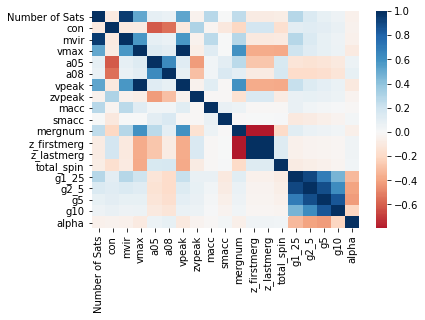

In [42]:
sns.heatmap(halo_combined_sample[['Number of Sats']+halo_features_all].corr(),
                    cmap = 'RdBu', center = 0.0);

Looking at the heatmap, the response is correlated the most with $mvir$, followed by $vmax$ and $vpeak$. Let's look at the correlation coefficient for these variables more closely.

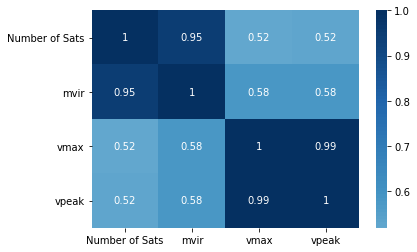

In [43]:
sns.heatmap(halo_combined_sample[['Number of Sats','mvir','vmax','vpeak']].corr(),
                    cmap = 'RdBu', center = 0.0, annot = True);

Indeed, there is a strong correlation between `Number of Satellites` and $mvir$. One can see that in the scatter plot below as well. 

Text(0, 0.5, 'Number of Satellites')

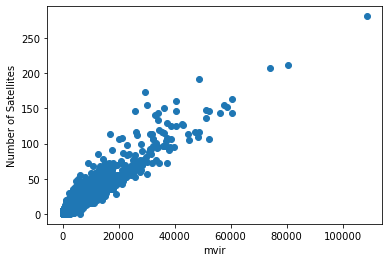

In [102]:
plt.scatter(halo_combined_sample['mvir'], halo_combined_sample['Number of Sats'])
plt.xlabel('mvir')
plt.ylabel('Number of Satellites')

### Outliers

Let's see if the full data has any outliers starting with taking a look at the descriptive statistics of the columns.

In [119]:
def z_score_func(df, features, axis):
    '''
    A function that calculates the z-scores of a dataframe provided the features. The dataframe is returned wih a column named 'outliers' containing boolean values, True if an outlier is present and False if not.   
    '''
    means = np.array(df[features].mean(axis=axis))   
    std_devs = np.array(df[features].std(axis=axis)) 
    z_scores = (df[features] - means)/std_devs    
    outliers = abs(z_scores) > 3    
    flag = np.any(outliers,axis=1)    
    df['outliers'] = flag
    return df

In [122]:
halo_combined = z_score_func(halo_combined, halo_features_all, 0)

In [118]:
outlier_df = halo_combined[halo_combined['outliers'] == True]
outlier_df.shape

(564655, 37)

The number of outliers is about 12% of the data set. Again, let's keep it and in the end we'll check how much the presence of outliers affects the performance of the model.

## Stratification

Instead of randomly ampling the training set, we do stratified sampling. For this, we also use the prior knowledge that for satellites the most important feature is $m_{\textrm{vir}}$. We first bin $m_{\textrm{vir}}$ in bins of $ (0,10^0], (10^0,10^1], ..., (10^5,10^6] $ and stratify the sample based on these bins. In reality though, the distribution of halos from stratification is indistinguishable from random sampling. The training size is 80%. 

In [128]:
N = 7
bins = np.zeros(N+1)
bins[1:] = 10**np.linspace(0,6,N)
labels = np.linspace(0,6,N)
halo_combined['Sats Categories'] = pd.cut(halo_combined['mvir'],bins = bins,
                                         labels=labels,right=True)


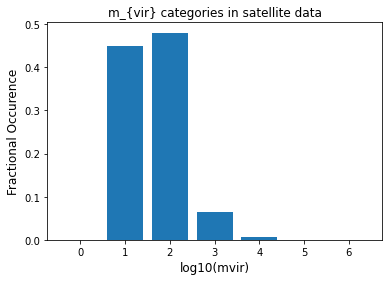

In [114]:
with PdfPages('mvir_dist_full.pdf') as pdf:
    col = halo_combined['Sats Categories'].value_counts()
    xvals = np.asarray(col.index.values)
    yvals = np.asarray(col)
    ind = np.argsort(xvals)
    xvals = xvals[ind]
    yvals = yvals[ind]
    plt.bar(xvals, yvals/np.sum(yvals))
    plt.xlabel('log10(mvir)', fontsize=12)
    plt.ylabel('Fractional Occurence', fontsize=12)
    plt.title(r'm_{vir} categories in satellite data', fontsize=12);
    pdf.savefig()

In [131]:
#random_state = np.array([random.randint(0,100)])
random_state = np.array([1])
frac = 0.1
split = StratifiedShuffleSplit(n_splits=1, test_size=frac, random_state=random_state[0])
df = halo_combined
for train_index, test_index in split.split(df,df['Sats Categories']):
    strat_rem_set = df.loc[train_index]
    strat_test = df.loc[test_index]
strat_rem_set = index_reset_drop(strat_rem_set)
strat_test = index_reset_drop(strat_test)

test_set_sample = strat_test

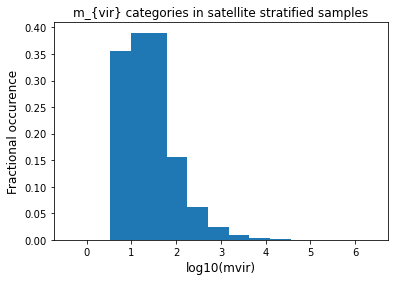

In [125]:
with PdfPages('mvir_dist_sample_strat.pdf') as pdf:
    col = strat_rem_set['Sats Categories'].value_counts()
    xvals = np.asarray(col.index.values)
    yvals = np.asarray(col)
    ind = np.argsort(xvals)
    xvals = xvals[ind]
    yvals = yvals[ind]
    plt.bar(xvals, yvals/np.sum(yvals))
    plt.xlabel('log10(mvir)', fontsize=12)
    plt.ylabel('Fractional occurence', fontsize=12)
    plt.title(r'm_{vir} categories in satellite stratified samples', fontsize=12);
    pdf.savefig()

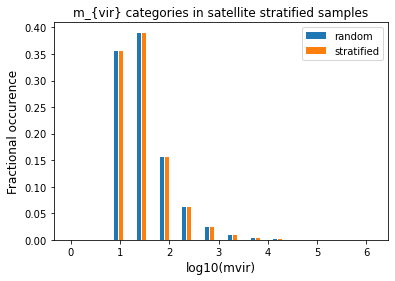

In [126]:
Nloop = 10
yvals_avg = np.zeros_like(yvals.astype(float))
yvals_tem = np.zeros_like(yvals.astype(float))
yvals_std = np.zeros_like(yvals.astype(float))
yvals_i = np.zeros((len(yvals),Nloop))

for i in range(Nloop):
    rand_train_set = halo_combined.sample(frac=0.89,replace=False,random_state=i)
    col = rand_train_set['Sats Categories'].value_counts()
    xvals = np.asarray(col.index.values)
    yvals_i[:,i] = np.asarray(col)
    yvals_tem = yvals_i[:,i].copy()
    ind = np.argsort(xvals)
    yvals_i[:,i] = yvals_tem[ind].copy()
    yvals_avg += yvals_tem[ind]
    yvals_i[:,i] /= np.sum(yvals_i[:,i])
yvals_avg = yvals_avg/(i+1)
yvals_avg /= np.sum(yvals_avg)
yvals_std = np.std(yvals_i,axis=1)
xvals = xvals[ind]

with PdfPages('mvir_dist_sample_rand.pdf') as pdf:
    plt.bar(xvals, yvals_avg,yerr=yvals_std, width = 0.08,label='random')
    plt.bar(xvals+0.1, yvals/np.sum(yvals), width = 0.08,label='stratified')
    plt.xlabel('log10(mvir)', fontsize=12)
    plt.ylabel('Fractional occurence', fontsize=12)
    plt.title(r'm_{vir} categories in satellite stratified samples', fontsize=12);
    plt.legend()
    pdf.savefig()

## Model selection

Even though Stochastic Ridge regression does a good job in predicting the number of satellites ($R^2$ score of 0.9 +/- 0.004), an inherent property of linear regression models is that they can predict negative values. Ordinarily, this may not be a problem but in our problem satellite _number_ must be zero or above. Therefore, linear regression isn't well suited to our problem. 

Another problem with linear regression is that the residuals aren't randomly distributed around the $residual = 0$ line. There is a slight structure in the residuals meaning the assumption that the dependent function is linearly dependent on the features is not quite correct. 

Random forests are a better choice since by construction they cannot give negative values for satellite numbers. Moreover, the performance measures are better than linear regression scores ($R^2$ score of 0.932 +/- 0.0036). We therefore select the random forest algorithm for our problem.  

In [132]:
halo_features_all =  ['con','mvir','vmax','a05','a08','vpeak',
'zvpeak','macc','smacc','mergnum','z_firstmerg','z_lastmerg',
'total_spin','g1_25','g2_5','g5','g10','alpha']

feat_dict = {'top 4':['mvir','g2_5','g1_25','con'], 'all':halo_features_all, '2': ['mvir','con'],
        'hybrid':['mvir','g2_5','vmax','z_lastmerg']}
feat = 'all'

In [207]:
X = halo_combined[feat_dict[feat]].copy()
X_scale = scaler.fit_transform(X)
y = halo_combined['Number of Sats']

In [208]:
poly_features = PolynomialFeatures(degree=1, include_bias=True)
X_poly = poly_features.fit_transform(X_scale)
#X_poly = X_scale
X_train_poly, X_val_poly, y_train, y_val = train_test_split(X_poly, y, random_state = 1, test_size = 0.1)

### Grid search

In [62]:
param_grid = {'alpha':[1E-1,1E-2,1E-3],'max_iter':[500,1000,1500]}
grid = GridSearchCV(Ridge(solver='sag'), param_grid)
grid.fit(X_train_poly, y_train)

GridSearchCV(estimator=Ridge(solver='sag'),
             param_grid={'alpha': [0.1, 0.01, 0.001],
                         'max_iter': [500, 1000, 1500]})

In [63]:
grid.best_estimator_

Ridge(alpha=0.001, max_iter=500, solver='sag')

In [64]:
print(cross_validate(grid.best_estimator_.fit(X_train_poly, y_train), 
                     X_train_poly, y_train, 
                     cv=4, scoring=scoring))

{'fit_time': array([34.01587009, 30.31823111, 29.20326614, 45.62011218]), 'score_time': array([0.89075899, 0.66138291, 0.69380593, 1.75921273]), 'test_r2_adj': array([0.9367206 , 0.94764167, 0.93492602, 0.93152479]), 'test_mean_err': array([ 0.00138518, -0.00040252, -0.00083787,  0.00128383]), 'test_mean_sq_error': array([1.82321973, 1.53935517, 1.64794399, 2.41386806]), 'test_slope': array([0.93598899, 0.96885675, 0.95882689, 0.90533889]), 'test_intercept': array([0.02450536, 0.01277426, 0.01754491, 0.03717745])}


In [65]:
r2_vals = [0.9367206 , 0.94764167, 0.93492602, 0.93152479]
print('Mean', np.mean(r2_vals), '\n','Standard error', np.std(r2_vals)/2)

Mean 0.9377032700000001 
 Standard error 0.0030168709738092026


#### Note:

n = 0.00316 

Mean 0.79 
 Standard error 0.003

n = 0.0316

Mean 0.94
 Standard error 0.003

In [136]:
best_est = Ridge(alpha=0.01, max_iter=1500, solver='sag')
best_est.fit(X_train_poly, y_train)

Ridge(alpha=0.01, max_iter=1500, solver='sag')

### Feature importances

In [10]:
best_est.coef_

array([ 0.00000000e+00, -2.05806827e-02,  6.76041122e+02, -4.06080708e+00,
        1.14394174e-01,  2.65101021e-02,  1.59182782e+00, -2.20043283e-02,
        1.68403725e+01,  4.04828068e-01, -4.11618545e-01, -1.04489250e-01,
        1.17556852e-01,  8.65322206e-02,  4.14198530e+00, -2.06070141e+00,
        6.96639971e-01, -1.05057829e-01,  5.52366269e-02])

In [11]:
best_est.intercept_

-5.277123144617352

In [17]:
index = abs(best_est.coef_[1:]).argsort()[::-1]
[(feat_dict[feat][i],best_est.coef_[1:][i]) for i in index]

[('mvir', 676.2170918331661),
 ('macc', 15.712093064441973),
 ('g1_25', 4.114862167173567),
 ('vmax', -4.009463814783586),
 ('g2_5', -1.9567897873446642),
 ('vpeak', 1.5426622518975828),
 ('g5', 0.7033408831608271),
 ('mergnum', -0.3809432225462636),
 ('smacc', 0.30534143379934175),
 ('a05', 0.11543947515443641),
 ('total_spin', 0.11286374523701584),
 ('z_lastmerg', 0.10511569160407892),
 ('g10', -0.10226576088754394),
 ('z_firstmerg', -0.06999108173699307),
 ('alpha', 0.060884401479994896),
 ('a08', 0.04538907822564053),
 ('con', -0.03924074481356365),
 ('zvpeak', -0.02719658762256373)]

## Residuals

In [209]:
X_test_scaled = scaler.fit_transform(test_set_sample[feat_dict[feat]])
X_test_poly = poly_features.fit_transform(X_test_scaled)

In [211]:
preds = best_est.predict(X_test_poly)
true = test_set_sample['Number of Sats']
res = preds - true
res_mean = np.mean(res)
res_std = np.std(res)
z_res = (res - res_mean)/res_std

Text(0.5, 0, 'Number of satellites (predicted)')

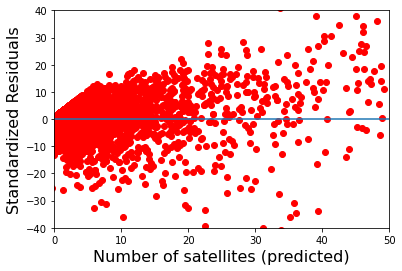

In [213]:
plt.scatter(preds,z_res,c='red')
plt.hlines(0,0,300)
plt.xlim(0,50)
plt.ylim(-40,40)
plt.ylabel('Standardized Residuals',fontsize=16)
plt.xlabel('Number of satellites (predicted)',fontsize=16)

Let's examine the normality of the residuals.

### Histogram

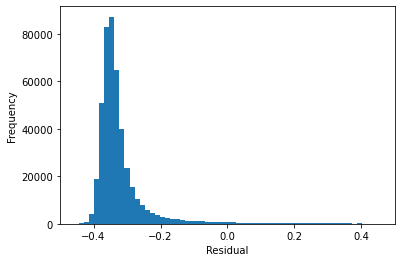

In [180]:
plt.hist(preds-true,bins=10000)
plt.xlim(-0.5,0.5)
plt.xlabel('Residual')
plt.ylabel('Frequency');

The histogram reveals that the residuals are anything but normal. We can also establish that with the QQ plot.

### QQ Plot

In [160]:
from scipy import stats
import statsmodels.api as sm

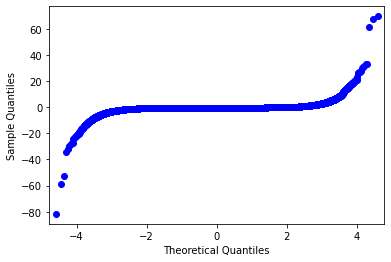

In [182]:
fig = sm.qqplot(preds-true, stats.norm)
plt.show()

In [184]:
stats.anderson(preds-true, dist='norm')

AndersonResult(statistic=122472.42122425267, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

The QQ plot shows a heavy tailed, right skewed distribution of residuals. The Anderson-Darling statistic is very large, meaning a small $p$-value implying that the null hypothesis, H0: The residuals are Gaussian, can be rejected. 

## Strategy

(1) Train a Random Forest (RF) Regression model on the halo data. The halo data contains halo properties and environment properties, or _features_, and the number of satellites, or the _ground truth_.

(2) Plot feature importances.

(3) Plot the correlation matrix of the features, and then select the 4 most important uncorrelated features.

(4) Run the RF regression model to predict the number of satellites for all halos in the data set.   


In [171]:
def bar_plot(rf, clmns, outfile):
    '''
    Bar plot in pdf.
    rf: RF model
    clmns: features
    outfile: output file name in pdf
    '''
    feature_imp = rf.feature_importances_
    features_arr = np.array(clmns)

    indices = np.argsort(feature_imp)
    print(feature_imp[indices],indices)

    with PdfPages(outfile) as pdf:
        fig = plt.figure(figsize=(12,12))
        ax = fig.add_subplot(111)
        plt.subplots_adjust(left = 0.2)
        #print(feature_imp[indices],indices)
        top_indices = indices[-10:]
        ax.set_xscale('log')
        ax.barh(range(len(top_indices)), feature_imp[top_indices])
        ax.set_yticks(range(len(top_indices)))
        ax.set_xticks([2E-3,1E-2,5E-2,2E-1,7E-1])
        ax.set_xticklabels([2E-3,1E-2,5E-2,2E-1,7E-1],fontsize=20)
        ax.set_yticklabels([features_arr[i] for i in top_indices],fontsize=20)
        pdf.savefig()

In [48]:
def corr_mat(correlation,outfile):
    with PdfPages(outfile) as pdf:
        f, ax_hm = plt.subplots(figsize=(15, 15))
        sns.set(font_scale=1.8)
        ax_hm = sns.heatmap(correlation,
                            cmap = 'RdBu', center = 0.0,
        xticklabels=correlation.columns,
        yticklabels=correlation.columns, annot = True, square = True)
        ax_hm.set_ylim(len(correlation), -0.01)
        ax_hm.set_xticklabels(ax_hm.get_xmajorticklabels(), fontsize = 18)
        ax_hm.set_yticklabels(ax_hm.get_ymajorticklabels(), fontsize = 18)
        pdf.savefig()    

In [49]:
def adj_r2(r2,n,p):
    """
    Adjusted r^2
    """
    return 1. - (1. - r2**2)*(n-1)/(n-p-1)

In [50]:
def ymodel(x,m,c):
    return m*x+c

## Grid Search

### Performance metrics

$R^2$ score, mean error, mean square error, slope, intercept

In [45]:
def y_pred_adj_func(y_pred):
    return np.where(np.random.uniform(np.floor(y_pred),
        np.ceil(y_pred)) < y_pred, np.ceil(y_pred), np.floor(y_pred))

def r2_adj(y_true, y_pred):
    y_pred_adj = y_pred_adj_func(y_pred)
    return r2_score(y_true,y_pred_adj)

def mean_error(y_true, y_pred):
    y_pred_adj = y_pred_adj_func(y_pred)
    return np.sum(y_true - y_pred_adj)/(len(y_true)-2)

def mean_sq_error(y_true, y_pred):
    y_pred_adj = y_pred_adj_func(y_pred)
    return np.sum((y_true-y_pred_adj)**2)/(len(y_true)-2)

def slope(y_true, y_pred):
    y_pred_adj = y_pred_adj_func(y_pred)
    (p, C) = opt.curve_fit(ymodel, y_true, y_pred_adj)
    return p[0]

def intercept(y_true, y_pred):
    y_pred_adj = y_pred_adj_func(y_pred)
    (p, C) = opt.curve_fit(ymodel, y_true, y_pred_adj)
    return p[1]

scoring = {'r2_adj': make_scorer(r2_adj), 'mean_err': make_scorer(mean_error),
        'mean_sq_error': make_scorer(mean_sq_error), 'slope': make_scorer(slope),
        'intercept': make_scorer(intercept)}

### Grid

In [ ]:
n_estimators = np.array([150,200,300])
max_depth = np.array([15,20,25])
min_samples_leaf = np.array([1,10,50])
#n_estimators = np.array([200])
#max_depth = np.array([20])
#min_samples_leaf = np.array([1])
frac = np.array([0.89])

In [ ]:
X_test = test_set_sample[feat_dict[feat]]
y_test = test_set_sample['Number of Sats']

In [ ]:
for a in range(0,rand_N):
    for f in frac:
#        random_state = np.array([random.randint(1,1000)])
        random_state = np.array([100])
        split = StratifiedShuffleSplit(n_splits=1, train_size=f,
                                  random_state=random_state[0])
        df = strat_rem_set
        for train_index, test_index in split.split(df,df['Sats Categories']):
            strat_train_set = df.loc[train_index]
        strat_train_set = index_reset_drop(strat_train_set)

        halo_sample_shuffle = strat_train_set
        y_train = halo_sample_shuffle['Number of Sats'].to_numpy()
        X_train = halo_sample_shuffle[feat_dict[feat]]

         for e in n_estimators:
            for d in max_depth:
                for l in min_samples_leaf:
                    rfreg = RandomForestRegressor(n_estimators = e,
                       max_depth = d,
                       min_samples_leaf = l,
                       n_jobs = -1,
                       random_state = random_state[0],
                       max_features=1.0)

                    print(e,d,l,cross_validate(rfreg.fit(X_train, y_train), X_train, y_train, cv=4, scoring=scoring))

## Visualizations from from grid search

In [144]:
image_path = "/Users/saurabh/Dropbox/Assembly_Bias/draft/Plots/"

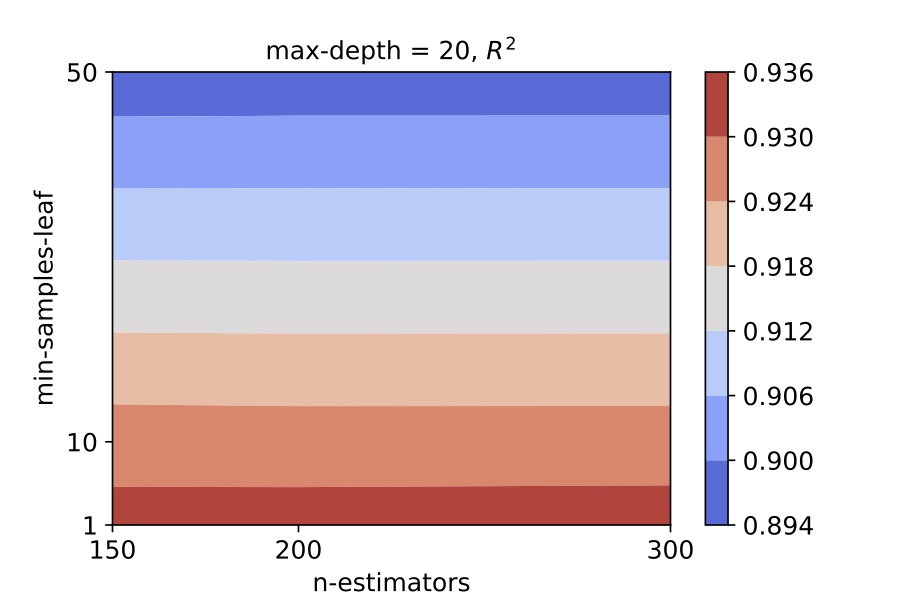

In [145]:
Image(image_path+"grid_max_depth_20_test_all_r2_80pct_cv.jpg")

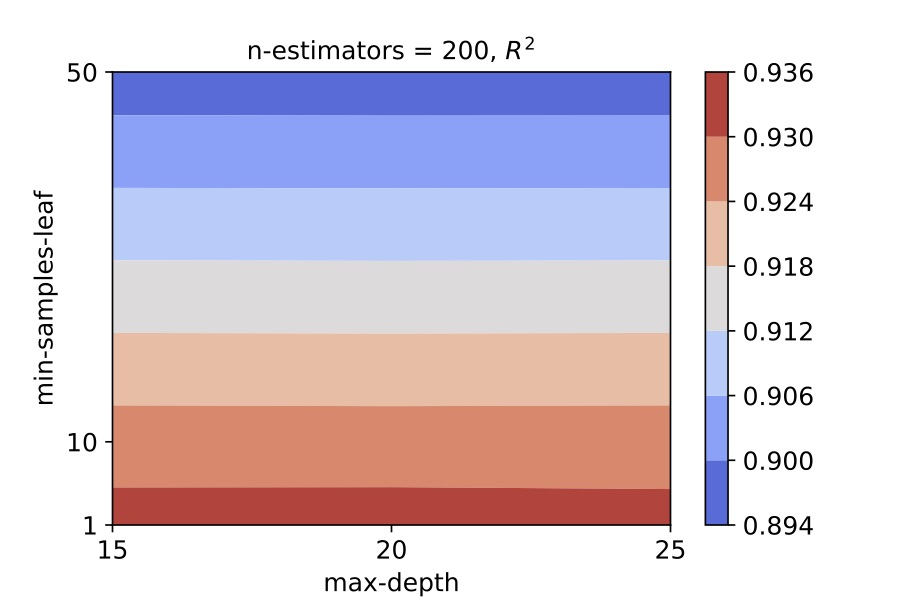

In [146]:
Image(image_path+"grid_n_estimators_200_test_all_r2_80pct_cv.jpg")

### Test individual models here

In [31]:
start = time.time()
halo_features_all =  ['con','mvir','vmax','a05','a08','vpeak',
'zvpeak','macc','smacc','mergnum','z_firstmerg','z_lastmerg',
'total_spin','g1_25','g2_5','g5','g10','alpha']

frac = 0.89
split = StratifiedShuffleSplit(n_splits=1, train_size=frac, random_state=random_state[0])

df = strat_rem_set
for train_index, test_index in split.split(df,df['Sats Categories']):
    strat_train_set = df.loc[train_index]
strat_train_set = index_reset_drop(strat_train_set)

halo_sample_shuffle = strat_train_set
y_train = halo_sample_shuffle['Number of Sats'].to_numpy()

feat_dict = {'top 5':['mvir','g2_5','g1_25','vmax','con'], 'all':halo_features_all, '2': ['mvir','con']}
feat = 'all'

n_estimators = 200
max_depth = 20
min_samples_leaf = 1

rfreg = RandomForestRegressor(n_estimators = n_estimators,
        max_depth = max_depth, 
        min_samples_leaf = min_samples_leaf,
        n_jobs = -1,
        random_state = random_state[0],
        max_features=1.0)

X_train = halo_sample_shuffle[feat_dict[feat]]
rfreg.fit(X_train, y_train)

y_test = test_set_sample['Number of Sats']
X_test = test_set_sample[feat_dict[feat]]
pred_test = rfreg.predict(X_test)
pred_test_adj = np.where(np.random.uniform(np.floor(pred_test),
                 np.ceil(pred_test)) < pred_test, 
                 np.ceil(pred_test), np.floor(pred_test))
print('r2 = ', r2_score(y_test,pred_test_adj))
print('sse = ', np.sum((y_test - pred_test_adj)**2))
print('me = ', np.sum(y_test - pred_test_adj)/(len(X_test)-2))
print('sigma2 = ', np.sum((y_test - pred_test_adj)**2)/(len(X_test)-2))
(p, C) = opt.curve_fit(ymodel, y_test, pred_test_adj)
print('slope = ', p[0])
print('intercept = ', p[1])

end = time.time()
print('time = ','{:2.2}'.format(end - start),'seconds')

r2 =  0.8644774431845126
sse =  239510.0
me =  -0.00015637658086949723
sigma2 =  0.5201910400562956
slope =  0.8051572394022274
intercept =  0.021861633808142704
time =  1.1e+04 seconds


[0.00072731 0.00088569 0.00120461 0.00121078 0.00130819 0.00140356
 0.00157906 0.00158623 0.00173528 0.00183628 0.00195673 0.00225476
 0.00231473 0.00650748 0.00810733 0.01075014 0.2368599  0.71777193] [ 9 10  6  8 11  7 16 17  3  2  5 12  4  0 15 13 14  1]


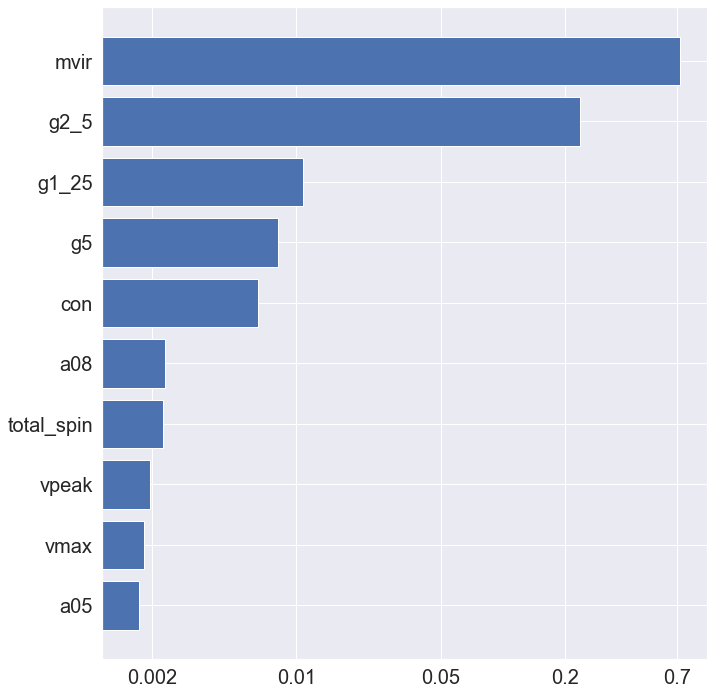

In [172]:
bar_plot(rfreg, X_train.columns,'feature_imp_rfreg_200_20_1_cut.pdf')

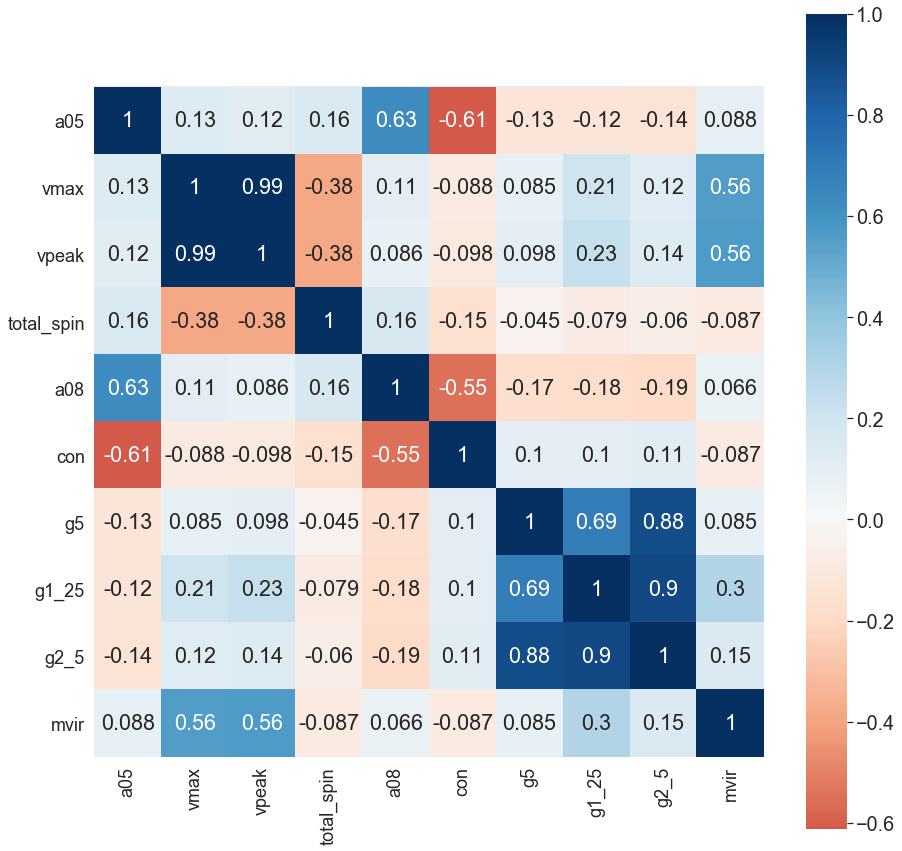

In [155]:
# View correlation among top 7 features

feature_imp = rfreg.feature_importances_
features_arr = np.array(X_train.columns)

indices = np.argsort(feature_imp)

feature_pos = indices[-10:]
halo_features_top = features_arr[feature_pos]
X = halo_combined[halo_features_top]

corr_mat(X.corr(),'heatmap_sat_rfreg_top.pdf')

In [57]:
X_total = halo_combined[feat_dict[feat]]
pred_total = rfreg.predict(X_total)
true_total = halo_combined['Number of Sats']
print('Total R^2 score', '{:1.3f}'.format(r2_score(true_total,pred_total)))

pred_total_adj = np.where(np.random.uniform(np.floor(pred_total),
                np.ceil(pred_total)) < pred_total, 
                np.ceil(pred_total), np.floor(pred_total))

halo_combined[f'Sat predicted ({feat},{str(frac)},{str(n_estimators)},{str(max_depth)},{str(min_samples_leaf)},{str(random_state[0])})'] = pred_total_adj

Training R^2 score 0.989
Test R^2 score 0.873
Total R^2 score 0.832


In [58]:
print('Satellite fraction predicted = ', 
      (1.0 - (np.sum(pred_total_adj)/np.sum(true_total)))*100, 'percent')

Satellite fraction predicted =  0.6427645002609839 percent


In [35]:
pred_sample = rfreg.predict(X_train)
pred_sample_adj = np.where(np.random.uniform(np.floor(pred_sample),
                np.ceil(pred_sample)) < pred_sample, 
                np.ceil(pred_sample), np.floor(pred_sample))
print('Training rounded off R^2 score', '{:1.3f}'.format(r2_score(y_train,pred_sample_adj)))


Training rounded off R^2 score 0.981


In [36]:
occpn_train = X_train.copy()
occpn_train['Sat predicted'] = pred_sample_adj
occpn_train = index_reset_drop(occpn_train)
occpn_train['Number of Sats'] = y_train

In [37]:
pred_test_adj = pred_test
pred_test_adj = np.where(np.random.uniform(np.floor(pred_test),
                np.ceil(pred_test)) < pred_test, 
                np.ceil(pred_test), np.floor(pred_test))
print('Test R^2 rounded off = ', '{:0.3f}'.format(r2_score(y_test,pred_test_adj)))

occpn_sample = test_set_sample
occpn_sample['Sat predicted'] = pred_test_adj
occpn_sample = index_reset_drop(occpn_sample)
occpn_sample['Number of Sats'] = y_test

Test R^2 rounded off =  0.882


In [63]:
sat_cols = ['fofID'] + list(halo_combined.columns.values[32:])
satellite = pd.DataFrame(columns = sat_cols)
satellite[sat_cols] = halo_combined[sat_cols]
satellite = satellite.rename(columns = {'Number of Sats':'Number of Satellites (True)'})
satellite.to_csv('satellite_01.txt', header=list(satellite.columns.values), index=None, sep=',')

### Satellite Top Features

Let's check multicollinearity amongst the top features of satellites.

In [126]:
sat_top = ['mvir','g2_5','g1_25','con']
vif_values = [vif(halo_combined_sample[sat_top].values, i)
                          for i in range(len(sat_top))]
vif_feat_vals = {sat_top[ind]: vals for ind,vals in enumerate(vif_values)}
vif_feat_vals = sorted(vif_feat_vals.items(), key = lambda item: item[1], reverse = True)
vif_feat_vals

[('g2_5', 9.462856500214867),
 ('g1_25', 8.563716298387341),
 ('con', 1.6583369768315908),
 ('mvir', 1.199032890607571)]

Taking 10 as the threshold value for VIF, there is some but not a great amount of multicollinearity amongst the top satellite features.

## Predicting Central galaxy occupation: Classification 

In [8]:
def plot_conf_matrix(matrix,outfile):
    matrix_dnsty = np.zeros((2,2))
    matrix_dnsty[0,:] = matrix[0,:]/np.sum(matrix[0,:])
    matrix_dnsty[1,:] = matrix[1,:]/np.sum(matrix[1,:])
    cmap = ListedColormap(['w','y'])
    plt.matshow(matrix_dnsty,cmap=cmap)
    #plt.colorbar()
    plt.xlabel('Predicted')
    plt.ylabel('True')
    for i in range(2):
        for j in range(2):
            plt.text(i,j,str(np.around(matrix_dnsty.T[i,j],decimals=3)))
    with PdfPages(outfile) as pdf:
        pdf.savefig()

In [9]:
def f2_score(true, pred):
    tn, fp, fn, tp = confusion_matrix(true, pred).ravel()
    p = tp/(tp+fp)
    r = tp/(tp+fn)
    return (5 * p * r) / (4 * p + r)

In [23]:
cent_data_cp_all = cent_data.copy()

#stellarMass_cut = 3.88 # n = 0.00316
#stellarMass_cut = 1.42 # n = 0.01
stellarMass_cut = 0.185 # n = 0.0316

cent_data_cp_all.loc[cent_data_cp_all['stellarMass'] < stellarMass_cut, 
                   'stellarMass'] = 0
cent_data_cp_all.loc[cent_data_cp_all['stellarMass'] >= stellarMass_cut, 
                   'stellarMass'] = 1
cent_data_cp_all['stellarMass'] = cent_data_cp_all['stellarMass'].astype(int)

#cent_data_cp = cent_data_cp_all
cent_data_cp = cent_data_cp_all[cent_data_cp_all['mvir'] > 10**0.7]
cent_data_cp = index_reset_drop(cent_data_cp)

In [69]:
#dill.dump(cent_data_cp, open('/Users/saurabh/Google_Drive/Assembly_Bias/central/cent_data_cp.pkd', 'wb'))

In [2]:
cent_data_cp = dill.load(open('/Users/saurabh/Google_Drive/Assembly_Bias/central/cent_data_cp.pkd', 'rb'))

In [34]:
path = '/Users/saurabh/Google_Drive/Assembly_Bias/central/'
!wget --directory-prefix=$path -nc https://assemblybias.s3.us-east-2.amazonaws.com/central/cent_data_cp.pkd.zip
!unzip -u $path/cent_data_cp.pkd.zip -d $path
cent_data_cp = dill.load(open(path+'cent_data_cp.pkd', 'rb'))

--2021-01-02 09:42:27--  https://assemblybias.s3.us-east-2.amazonaws.com/central/cent_data_cp.pkd.zip
Resolving assemblybias.s3.us-east-2.amazonaws.com... 52.219.97.194, 52.219.97.194, 52.219.100.232
Connecting to assemblybias.s3.us-east-2.amazonaws.com|52.219.97.194|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 609433398 (581M) [application/zip]
Saving to: '/Users/saurabh/Google_Drive/Assembly_Bias/central/cent_data_cp.pkd.zip'

cent_data_cp.pkd.zi 100%[===================>] 581.20M  1.43MB/s    in 4m 36s  

2021-01-02 09:47:03 (2.11 MB/s) - '/Users/saurabh/Google_Drive/Assembly_Bias/central/cent_data_cp.pkd.zip' saved [609433398/609433398]

Archive:  /Users/saurabh/Google_Drive/Assembly_Bias/central//cent_data_cp.pkd.zip
  inflating: /Users/saurabh/Google_Drive/Assembly_Bias/central/cent_data_cp.pkd  


## Model selection

We start with the simplest model, Logistic Regression. We find that the $F_1$ and $F_2$ scores are 0.776 +/- 0.0004 and 0.776 +/- 0.0005 respectively. However, comparing the scores to the Random Forest Classifier which are 0.893 +/- 0.0002 and 0.892 +/- 0.0002 respectively, the random forest method clearly performs better. We therefore select random forest classifier as our final model.   

In [11]:
halo_features_all =  ['con','mvir','vmax','a05','a08','vpeak',
'zvpeak','macc','smacc','mergnum','z_firstmerg','z_lastmerg',
'total_spin','g1_25','g2_5','g5','g10','alpha']

feat_dict = {'top 4':['mvir','g2_5','g1_25','con'], 'all':halo_features_all, '2': ['mvir','con'],
        'hybrid':['mvir','g2_5','vmax','z_lastmerg']}
feat = 'all'

In [24]:
X = cent_data_cp[feat_dict[feat]].copy()
X_scale = scaler.fit_transform(X)
y = cent_data_cp['stellarMass']

In [25]:
poly_features = PolynomialFeatures(degree=1, include_bias=True)
X_poly = poly_features.fit_transform(X_scale)
X_train_poly, X_val_poly, y_train, y_val = train_test_split(X_poly, y, random_state = 1, test_size = 0.1)

### Grid search

In [26]:
t0 = time.time()
param_grid = {'C':[1E-1,1E-2]}
grid = GridSearchCV(LogisticRegression(solver='sag'), param_grid)
grid.fit(X_train_poly, y_train)
print((time.time()-t0)/60)

4.960184518496195


In [27]:
grid.best_estimator_

LogisticRegression(C=0.1, solver='sag')

In [28]:
best_est = grid.best_estimator_
best_est.fit(X_train_poly, y_train)

LogisticRegression(C=0.1, solver='sag')

### Feature importances

In [29]:
index = abs(best_est.coef_[0][1:]).argsort()[::-1]
[feat_dict[feat][i] for i in index]

['vmax',
 'vpeak',
 'total_spin',
 'con',
 'g1_25',
 'a05',
 'smacc',
 'mergnum',
 'g2_5',
 'a08',
 'g5',
 'mvir',
 'alpha',
 'g10',
 'zvpeak',
 'z_lastmerg',
 'z_firstmerg',
 'macc']

In [30]:
print(cross_validate(grid.best_estimator_.fit(X_train_poly, y_train), 
                     X_train_poly, y_train, 
                     cv=4, scoring=scoring))

{'fit_time': array([23.78284597, 20.99759102, 22.7378161 , 21.37393904]), 'score_time': array([1.79500914, 1.68300104, 1.66027498, 2.06043482]), 'test_f1_adj': array([0.85167177, 0.85197067, 0.85152049, 0.85184689]), 'test_f2_adj': array([0.8515667 , 0.85254893, 0.85265366, 0.8536356 ])}


In [31]:
f1_vals = [0.85167177, 0.85197067, 0.85152049, 0.85184689]
f2_vals = [0.8515667 , 0.85254893, 0.85265366, 0.8536356 ]
print('F1: Mean', np.mean(f1_vals), '\n','Standard error', np.std(f1_vals)/2)
print('F2: Mean', np.mean(f2_vals), '\n','Standard error', np.std(f2_vals)/2)

F1: Mean 0.851752455 
 Standard error 8.545963444078118e-05
F2: Mean 0.8526012225 
 Standard error 0.0003662016019622151


#### Note: n = 0.00316

F1: Mean 0.6
Standard error 9E-4

F2: Mean 0.6 
Standard error 1E-3

#### Note: n = 0.0316

F1: Mean 0.85 
Standard error 9e-05
 
F2: Mean 0.85
Standard error 4e-4

### Data preparation

We go through the reduced sample of 4.6 milliom halos, classify halos with central galaxy mass < 1.42 as 0, and 1 otherwise thereby creating the ground truth. The total central number is 745,027.

With centrals as well we chose a stratified sample of size 80% to train on from the entire data set. We stratified our sample based on $v_{\text{max}}$, the most important feature for centrals, with bins of $ (0,10^0], (10^0,10^1], ..., (10^3,10^4] $  

In [207]:
N = 8
bins = np.zeros(N+1)
bins[1:] = 10**np.linspace(0,4,N)
labels = np.linspace(0,4,N)
cent_data_cp['Cent Categories'] = pd.cut(cent_data_cp['vmax'],bins = bins,
                                    labels=labels,right=True)

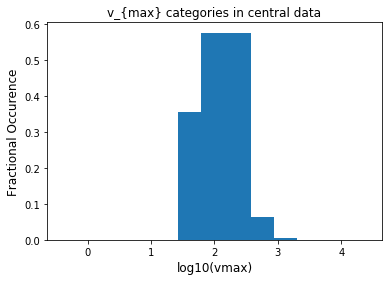

In [56]:
with PdfPages('vmax_dist.pdf') as pdf:
    col = cent_data_cp['Cent Categories'].value_counts()
    xvals = np.asarray(col.index.values)
    yvals = np.asarray(col)
    ind = np.argsort(xvals)
    xvals = xvals[ind]
    yvals = yvals[ind]    
    plt.bar(xvals, yvals/np.sum(yvals))
    plt.xlabel('log10(vmax)', fontsize=12)
    plt.ylabel('Fractional Occurence', fontsize=12)
    plt.title(r'v_{max} categories in central data', fontsize=12);
    pdf.savefig()

In [208]:
frac=0.1
random_state = np.array([random.randint(0,100)])
split = StratifiedShuffleSplit(n_splits=1, test_size=frac, random_state=random_state[0])

df = cent_data_cp
for train_index, test_index in split.split(df,df['Cent Categories']):
    strat_rem_set = df.loc[train_index]
    strat_test = df.loc[test_index]
strat_rem_set = index_reset_drop(strat_rem_set)
strat_test = index_reset_drop(strat_test)

test_set_sample = strat_test

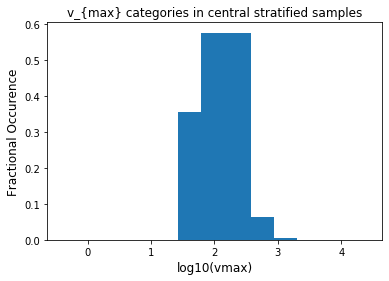

In [58]:
col = strat_train_set['Cent Categories'].value_counts()
xvals = np.asarray(col.index.values)
yvals = np.asarray(col)
ind = np.argsort(xvals)
xvals = xvals[ind]
yvals = yvals[ind]
plt.bar(xvals, yvals/np.sum(yvals))
plt.xlabel('log10(vmax)', fontsize=12)
plt.ylabel('Fractional Occurence', fontsize=12)
plt.title(r'v_{max} categories in central stratified samples', fontsize=12);

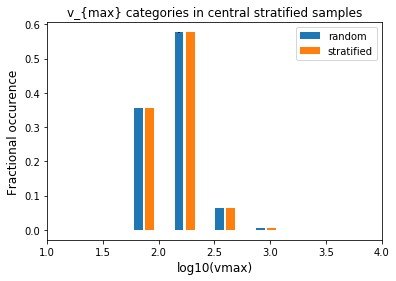

In [60]:
Nloop = 10
yvals_avg = np.zeros_like(yvals.astype(float))
yvals_tem = np.zeros_like(yvals.astype(float))
yvals_std = np.zeros_like(yvals.astype(float))
yvals_i = np.zeros((len(yvals),Nloop))

for i in range(Nloop):
    rand_train_set = cent_data_cp.sample(frac=0.1,replace=False,random_state=i)
    col = rand_train_set['Cent Categories'].value_counts()
    xvals = np.asarray(col.index.values)
    yvals_i[:,i] = np.asarray(col)
    yvals_tem = yvals_i[:,i].copy()
    ind = np.argsort(xvals)
    yvals_i[:,i] = yvals_tem[ind].copy()
    yvals_avg += yvals_tem[ind]
    yvals_i[:,i] /= np.sum(yvals_i[:,i])
yvals_avg = yvals_avg/(i+1)
yvals_avg /= np.sum(yvals_avg)
yvals_std = np.std(yvals_i,axis=1)
xvals = xvals[ind]

with PdfPages('vmax_dist_sample_rand.pdf') as pdf:
    plt.xlim(1,4)
    plt.bar(xvals, yvals_avg,yerr=yvals_std, width = 0.08,label='random')
    plt.bar(xvals+0.1, yvals/np.sum(yvals), width = 0.08,label='stratified')
    plt.legend()
    plt.xlabel('log10(vmax)', fontsize=12)
    plt.ylabel('Fractional occurence', fontsize=12)
    plt.title(r'v_{max} categories in central stratified samples', fontsize=12);
    pdf.savefig()

## Grid Search

### Performance measures

In [19]:
def f1_adj(y_true, y_pred):
    X_proba = np.zeros((len(y_pred),2))
    X_proba[:,1] = y_pred
    X_proba[:,0] = 1. - y_pred
    pred_true_adj = np.where(np.random.uniform(np.rint(X_proba[:,0]),
        np.rint(X_proba[:,1])) < X_proba[:,1], 1, 0)
    return f1_score(y_true, pred_true_adj)

def f2_adj(y_true, y_pred):
    X_proba = np.zeros((len(y_pred),2))
    X_proba[:,1] = y_pred
    X_proba[:,0] = 1. - y_pred
    pred_true_adj = np.where(np.random.uniform(np.rint(X_proba[:,0]),
        np.rint(X_proba[:,1])) < X_proba[:,1], 1, 0)
    return f2_score(y_true, pred_true_adj)

scoring = {'f1_adj': make_scorer(f1_adj,needs_proba = True),
        'f2_adj': make_scorer(f2_adj,needs_proba = True)}

### Feature selection

In [ ]:
feat_dict = {'top+env':['vmax','z_lastmerg','mvir','a05','g1_25'],
        'all':halo_features_all, '2':['mvir','con'], 'top':['vmax','z_lastmerg','mvir','a05'],
        'hybrid':['mvir','g2_5','vmax','z_lastmerg']}
feat = 'hybrid'
X_test = test_set_sample[feat_dict[feat]]
y_test = test_set_sample['stellarMass']

X_total = cent_data_cp[feat_dict[feat]]
y_total = cent_data_cp['stellarMass']

### Grid

In [ ]:
n_estimators = np.array([150,200,300])
max_depth = np.array([15,20,25])
min_samples_leaf = np.array([1,10,50])

### Final grid search

In [ ]:
for a in range(0,rand_N):
    random_state = np.array([100])
    split = StratifiedShuffleSplit(n_splits=1, train_size=frac,
                                  random_state=random_state[0])
    df = strat_rem_set
    for train_index, test_index in split.split(df,df['Cent Categories']):
        strat_train_set = df.loc[train_index]
    strat_train_set = index_reset_drop(strat_train_set)

    central_both_shuffle = strat_train_set
    y_train = central_both_shuffle['stellarMass'].to_numpy()
    X_train = central_both_shuffle[feat_dict[feat]]

    for e in n_estimators:
        for d in max_depth:
            for l in min_samples_leaf:
                rfclass = RandomForestClassifier(n_estimators = e, 
                   max_depth = d,
                   min_samples_leaf = l, 
                   n_jobs = -1,
                   random_state = random_state[0],
                   max_features = 1.0)

                print(e,d,l,cross_validate(rfclass.fit(X_train, y_train), X_train, y_train, 
                    cv=4, scoring=scoring))

## Visualizations from from grid search

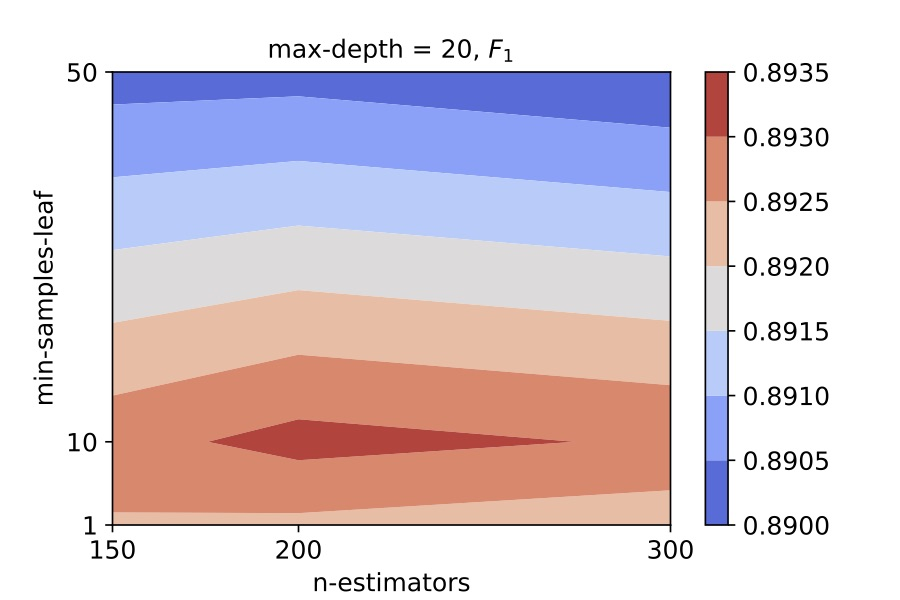

In [147]:
Image(image_path+"grid_max_depth_20_test_all_f1_80pct_cv.jpg")

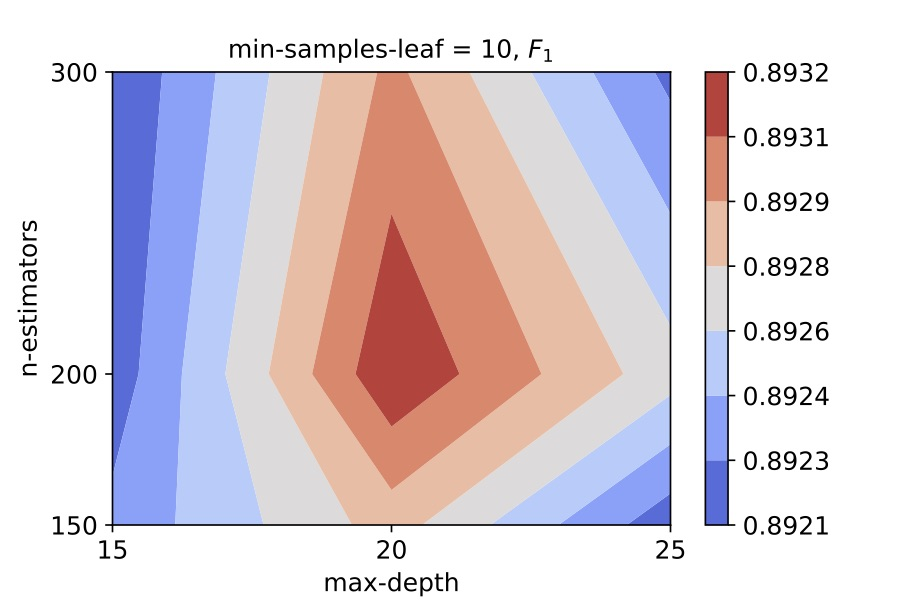

In [148]:
Image(image_path+"grid_min_samples_leaf_10_test_all_f1_80pct_cv.jpg")

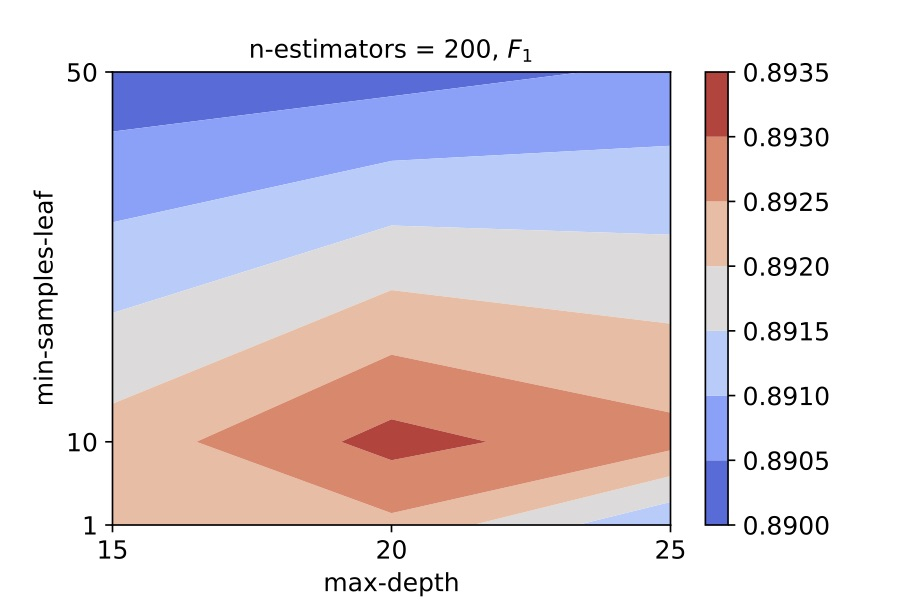

In [149]:
Image(image_path+'grid_n_estimators_200_test_all_f1_80pct_cv.jpg')

## Testing individual models

Test F1 score for RF =  0.878
Test F2 score for RF =  0.878
time =   1 minutes


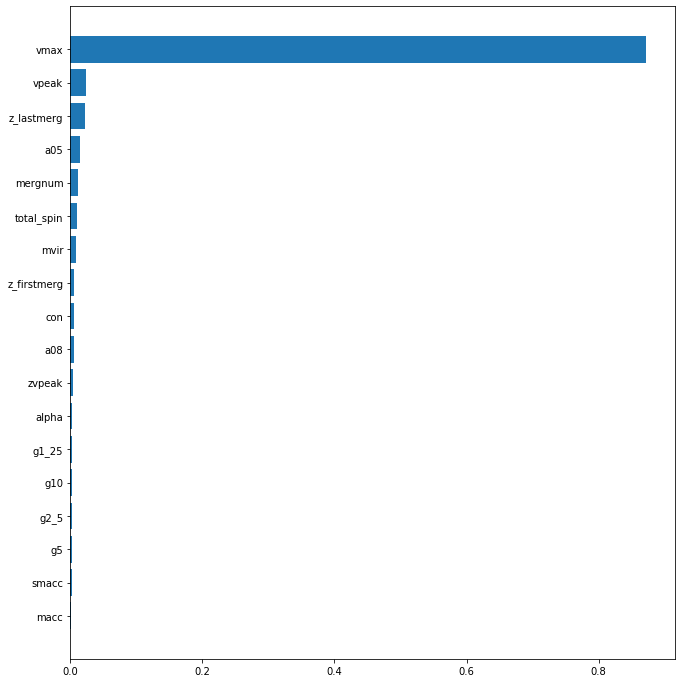

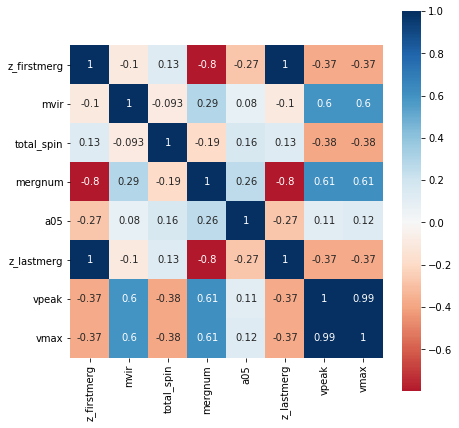

In [49]:
frac = 0.89
split = StratifiedShuffleSplit(n_splits=1, train_size=frac,
random_state=random_state[0])
df = strat_rem_set
for train_index, test_index in split.split(df,df['Cent Categories']):
    strat_train_set = df.loc[train_index]
strat_train_set = index_reset_drop(strat_train_set)

central_both_shuffle = strat_train_set

halo_features_all =  ['con','mvir','vmax','a05','a08','vpeak',
'zvpeak','macc','smacc','mergnum','z_firstmerg','z_lastmerg',
'total_spin','g1_25','g2_5','g5','g10','alpha']

y_train = central_both_shuffle['stellarMass'].to_numpy()
X_train = central_both_shuffle[halo_features_all]

X_test = test_set_sample[halo_features_all]
y_test = test_set_sample['stellarMass']

start = time.time()

n_estimators = 200
max_depth = 20
min_samples_leaf=10
rfclass = RandomForestClassifier(n_estimators = n_estimators, 
            max_depth = max_depth, 
            min_samples_leaf = min_samples_leaf,
            n_jobs = -1,
            random_state = random_state[0],
            max_features = 1.0)
rfclass.fit(X_train, y_train);
outfile = 'feature_full_cent_200_20_10_cut.pdf'
bar_plot(rfclass,X_train.columns,outfile)
    
feature_imp = rfclass.feature_importances_
features_arr = np.array(X_train.columns)
indices = np.argsort(feature_imp)
feature_pos = indices[-8:]
halo_features_top = features_arr[feature_pos]

X = central_both_shuffle[halo_features_top]
outfile = 'heatmap_cent.pdf'
corr_mat(X.corr(),outfile)
 
X_proba = rfclass.predict_proba(X_test)
pred_test_adj = np.where(np.random.uniform(np.rint(X_proba[:,0]),
np.rint(X_proba[:,1])) < X_proba[:,1], 1, 0)
print('Test F1 score for RF = ', '{:0.3f}'.format(f1_score(y_test,pred_test_adj)))
print('Test F2 score for RF = ', '{:0.3f}'.format(f2_score(y_test,pred_test_adj)))

end = time.time()

print('time = ','{:2.0f}'.format((end - start)/60.),'minutes')

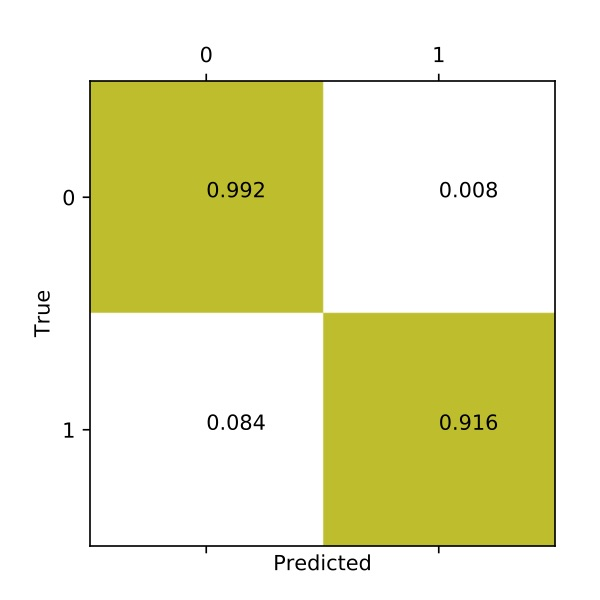

In [155]:
Image(image_path+'confusion_uncorr_all_onen_dens.jpg')

In [92]:
cen_cols = ['fofID','stellarMass'] + list(cent_data_cp.columns.values[36:])
central = pd.DataFrame(columns = cen_cols)
central[cen_cols] = cent_data_cp[cen_cols]
central = central.rename(columns = {'stellarMass':'Central Occupation (True)'})
#central.to_csv('central_01.txt', header=list(central.columns.values), index=None, sep=',')

### Centrals Top Features

Let's check the amount of multicollinearity amongst the top features centrals model.

In [125]:
central_top = ['vmax','z_lastmerg','a05','mvir']
vif_values = [vif(halo_combined_sample[central_top].values, i)
                          for i in range(len(central_top))]
vif_feat_vals = {central_top[ind]: vals for ind,vals in enumerate(vif_values)}
vif_feat_vals = sorted(vif_feat_vals.items(), key = lambda item: item[1], reverse = True)
vif_feat_vals

[('a05', 5.969250300659926),
 ('vmax', 5.4296605868165155),
 ('z_lastmerg', 2.010824194216917),
 ('mvir', 1.371849924314744)]

Taking 10 as a threshold value of VIF, there is some multicollinearity but it is not very high!

# Centrals & Satellites Combined

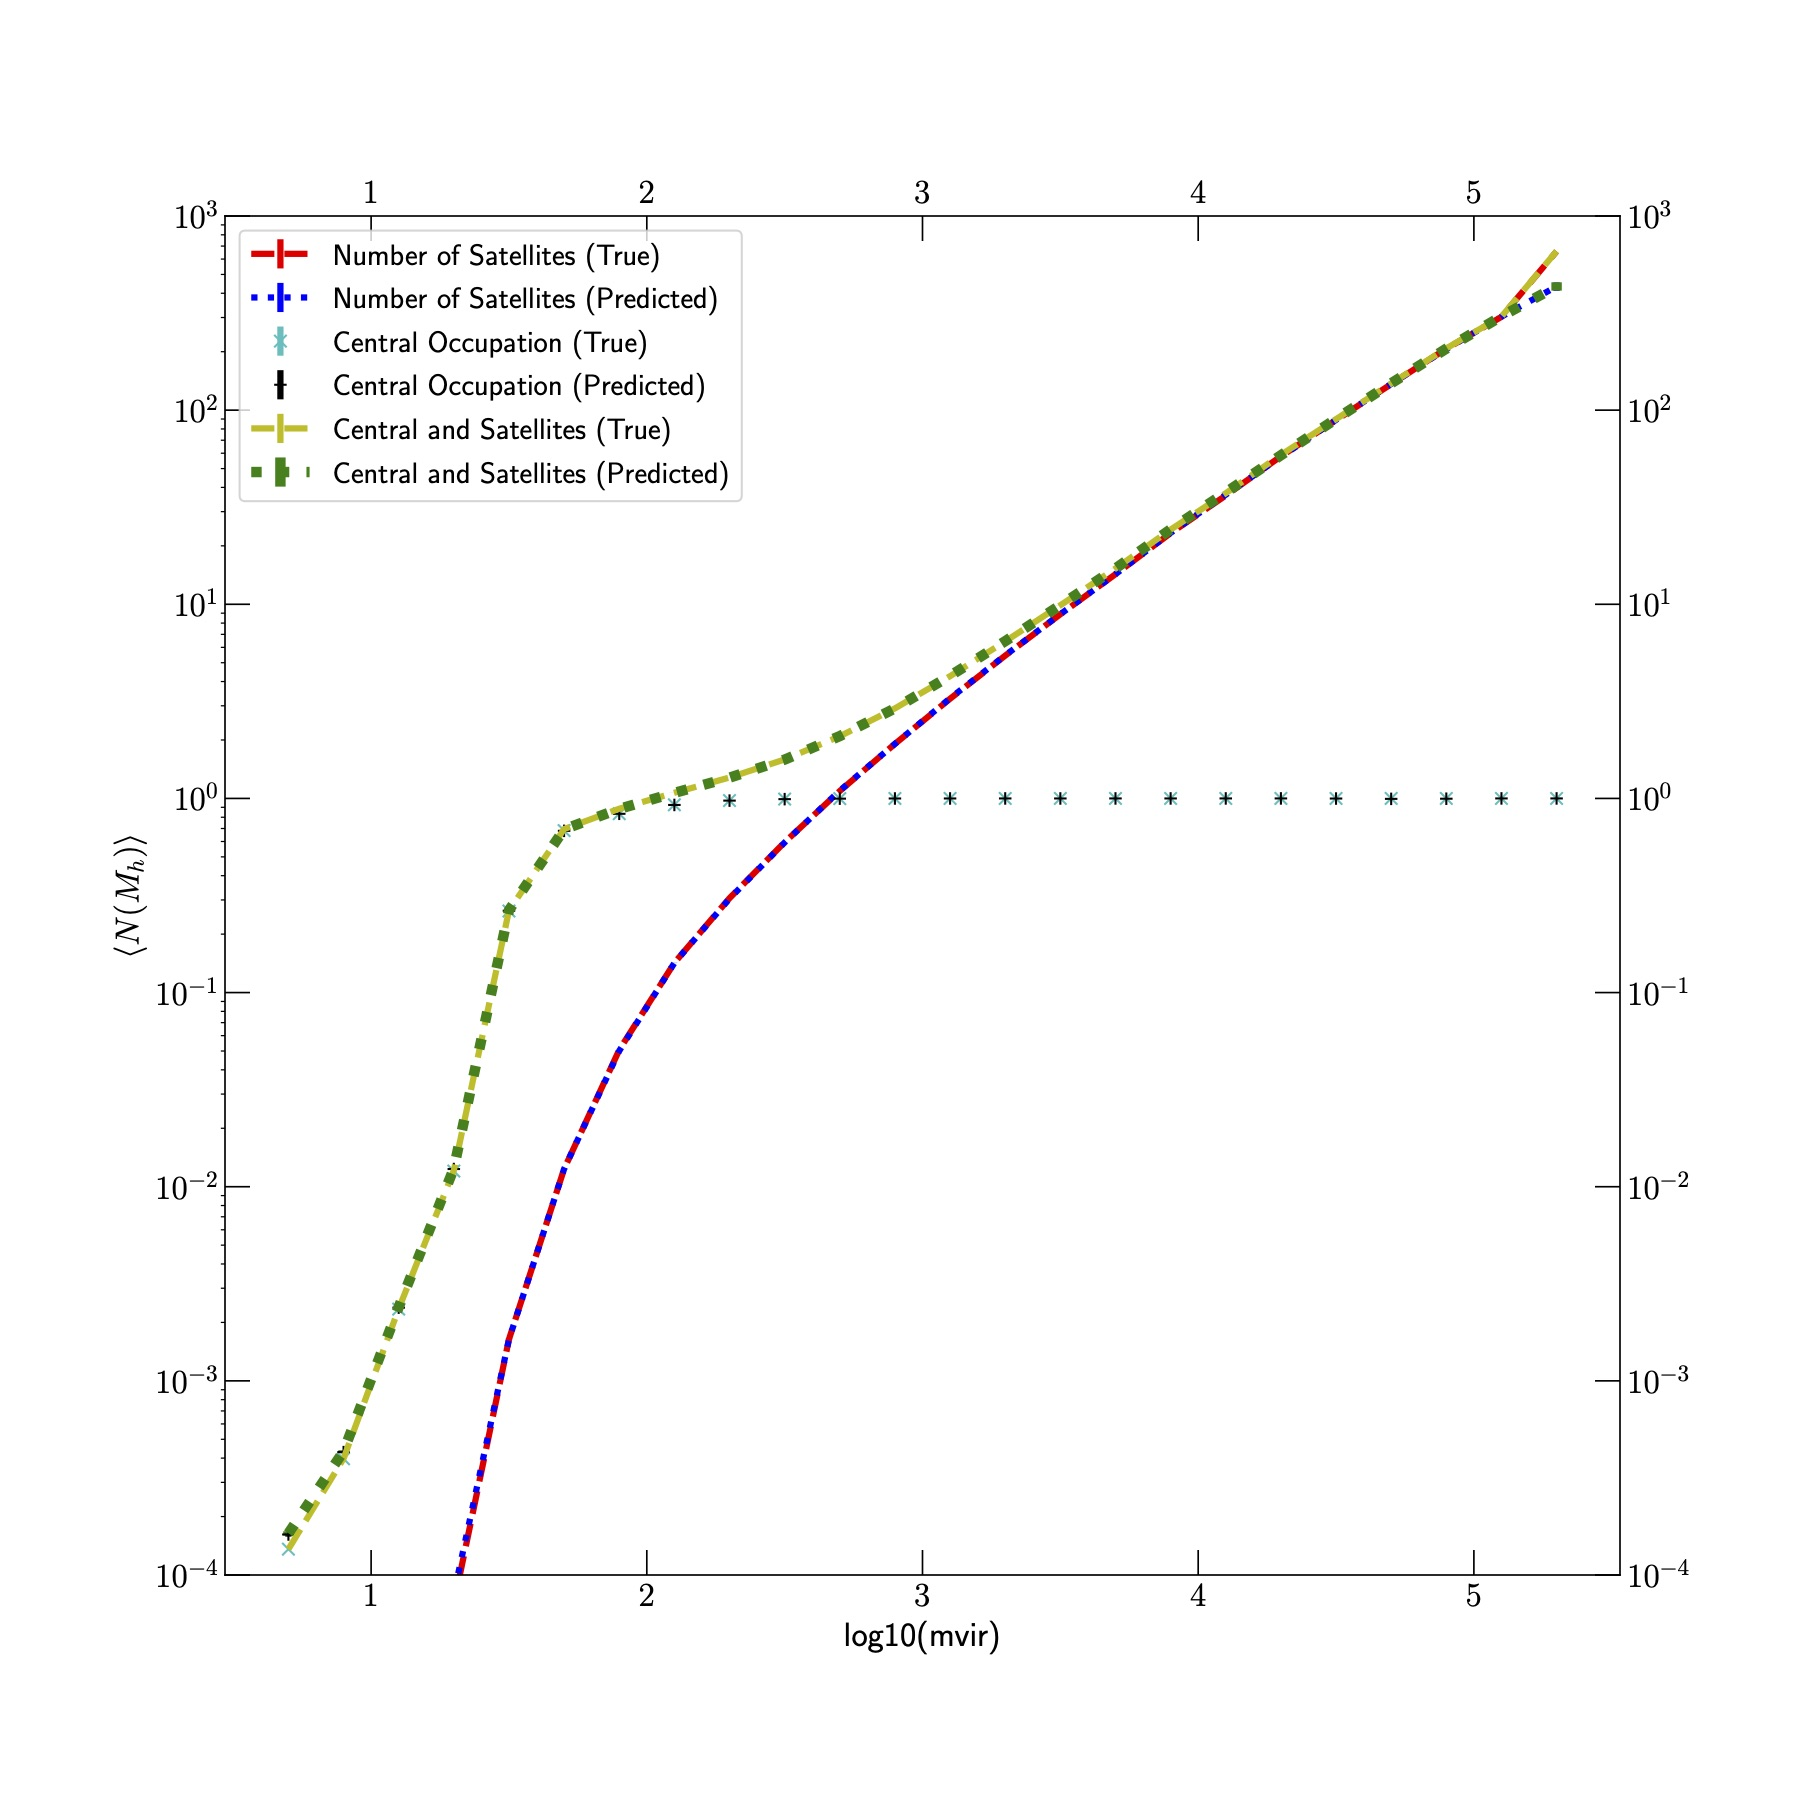

In [150]:
Image(image_path+'avg_ov_all_cut.jpg')

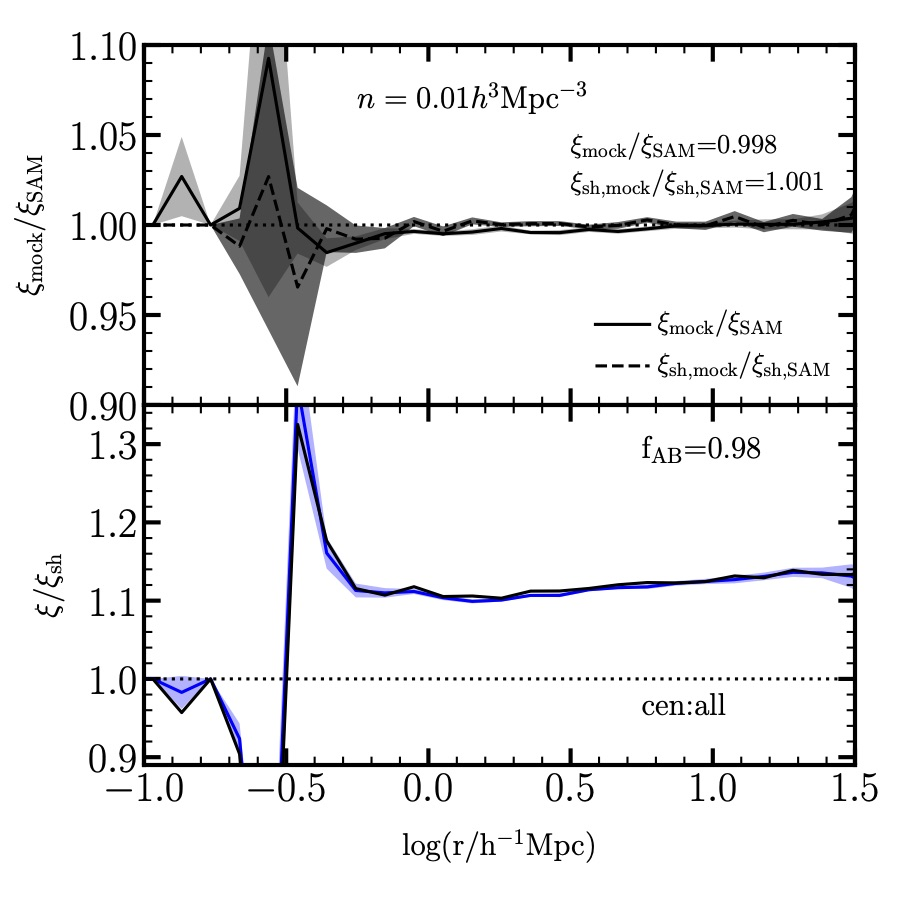

In [151]:
Image(image_path+"full-cenxi-all-D80-rand10.jpg")

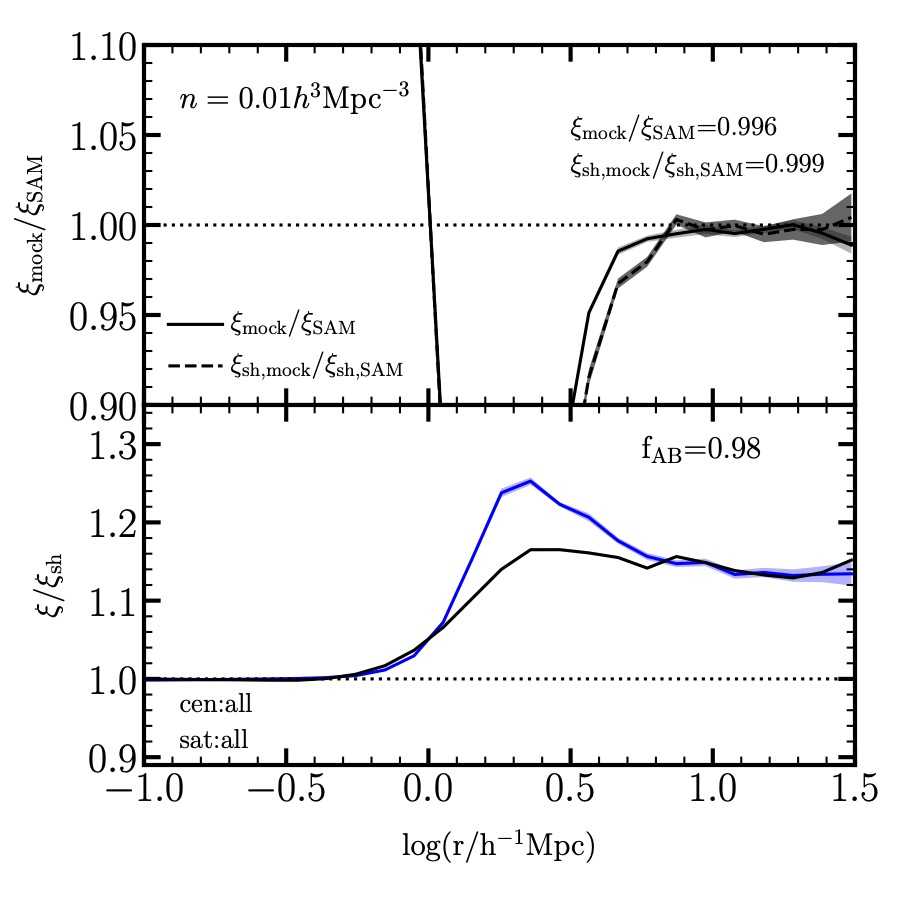

In [153]:
Image(image_path+'plot3-csall-D80-rand10.jpg')

In [95]:
halo_combined_sort = halo_combined.sort_values(by = 'fofID')
halo_combined_sort = index_reset_drop(halo_combined_sort)

In [96]:
cent_data_sat_sort = central.sort_values(by = 'fofID')
cent_data_sat_sort = index_reset_drop(cent_data_sat_sort)
cent_data_sat_sort.drop(columns=['fofID'])

col_cent = cent_data_sat_sort.columns
halo_combined_sort[col_cent] = cent_data_sat_sort[col_cent]

## Making final plots

In [79]:
df1 = halo_combined_final_sort

df['Number of Satellites (True)'] = df1['Number of Sats']
df['Number of Satellites (Predicted, top 5, 1.0)'] = df1['Sat predicted (top 5, 1.0)']

df['Central Occupation (True)'] = df1['central_0_or_1']
df['Central Occupation (Predicted)'] = df1['Cent predicted']
df['Central Occupation from environment (Predicted)'] = df1['Cent predicted from environment']
df['Central Occupation from all (Predicted)'] = df1['Cent predicted from all']

df['Central and Satellites Separate (Predicted)'] = df1['Sat predicted (top 5, 1.0)'] + df1['Cent predicted']
df['Central and Satellites Separate (Predicted, top5+env)'] = df1['Sat predicted (top 5, 1.0)'] + df1['Cent predicted from environment']
df['Central and Satellites Separate (Predicted, all)'] = df1['Sat predicted (top 5, 1.0)'] + df1['Cent predicted from all']
df['Central and Satellites (True)'] = df1['Central plus Sat']

halo_combined_final = df.copy()

In [ ]:
cent_sat_train = central[central['fofID'].isin(occpn_train.fofID)]
cent_sat_train_sort = cent_sat_train.sort_values(by = 'fofID')
cent_sat_train_sort = index_reset_drop(cent_sat_train_sort)

occpn_train_sort = occpn_train.sort_values(by = 'fofID')
occpn_train_sort = index_reset_drop(occpn_train_sort)

sat_df_train = occpn_train_sort.copy()
sat_df_train['Central Occupation (True)'] = cent_sat_train_sort['Central Occupation (True)']
sat_df_train['Central Occupation (Predicted)'] = cent_sat_train_sort['Central Occupation (Predicted)']
sat_df_train['Central and Satellites (True)'] = sat_df_train['Number of Sats'] 
+ cent_sat_train_sort['Central Occupation (True)']
sat_df_train['Central and Satellites (Predicted)'] = sat_df_train['Sat predicted'] 
+ cent_sat_train_sort['Central Occupation (Predicted)']
sat_df_train['Central and Satellites (Predicted, offset)'] = sat_df_train['Central and Satellites (Predicted)'] + 0.1 
sat_df_train['Central and Satellites (True, offset)'] = sat_df_train['Central and Satellites (True)'] + 0.1 


In [703]:
cent_sat_sample = central[central['fofID'].isin(occpn_sample.fofID)]
cent_sat_sample_sort = cent_sat_sample.sort_values(by = 'fofID')
cent_sat_sample_sort = index_reset_drop(cent_sat_sample_sort)

occpn_sample_sort = occpn_sample.sort_values(by = 'fofID')
occpn_sample_sort = index_reset_drop(occpn_sample_sort)

sat_df_sample = occpn_sample_sort.copy()
sat_df_sample['Central Occupation (True)'] = cent_sat_sample_sort['Central Occupation (True)']
sat_df_sample['Central Occupation (Predicted)'] = cent_sat_sample_sort['Central Occupation (Predicted)']
sat_df_sample['Central and Satellites (True)'] = sat_df_sample['Number of Sats'] 
+ cent_sat_sample_sort['Central Occupation (True)']
sat_df_sample['Central and Satellites (Predicted)'] = sat_df_sample['Sat predicted'] 
+ cent_sat_sample_sort['Central Occupation (Predicted)']
sat_df_sample['Central and Satellites (Predicted, offset)'] = sat_df_sample['Central and Satellites (Predicted)'] + 0.1 
sat_df_sample['Central and Satellites (True, offset)'] = sat_df_sample['Central and Satellites (True)'] + 0.1 


/Users/saurabh/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/Users/saurabh/opt/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


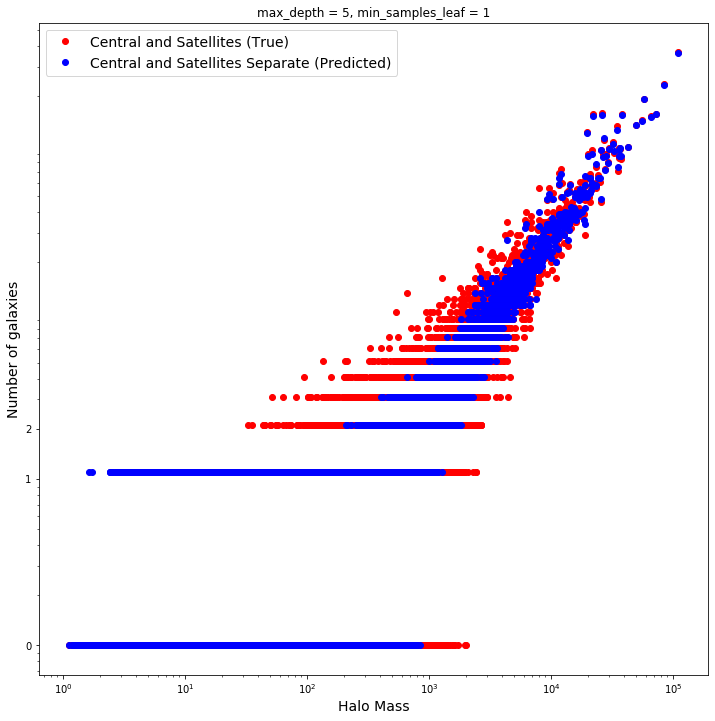

In [705]:
with PdfPages('occupation_train_5_1_top.pdf') as pdf:
    fig = plt.figure(figsize=(12,12))
    ax0 = fig.add_subplot(111)
    ax0.set_xscale('log')
    ax0.set_yscale('log')
    plot_df = sat_df_train
#    ax0.plot(plot_df['mvir'],plot_df['Central and Satellites (Predicted, offset)'],'bo',
#                 label = 'Central and Satellites Separate (Predicted)', 
#                 rasterized=True)
    ax0.plot(plot_df['mvir'],plot_df['Central and Satellites (True, offset)'],'ro',
                alpha = 1,
                 label = 'Central and Satellites (True)', rasterized=True)
    ax0.plot(plot_df['mvir'],plot_df['Central and Satellites (Predicted, offset)'],'bo',
             alpha = 1,    
             label = 'Central and Satellites Separate (Predicted)', 
                 rasterized=True)
    ax0.legend(fontsize=14)
    ax0.set_yticks([0.1,1,2])
    ax0.set_yticklabels([0, 1, 2])
    ax0.set_xlabel('Halo Mass', fontsize=14)
    ax0.set_ylabel('Number of galaxies', fontsize=14)
    ax0.set_title('max_depth = 5, min_samples_leaf = 1')
    pdf.savefig()

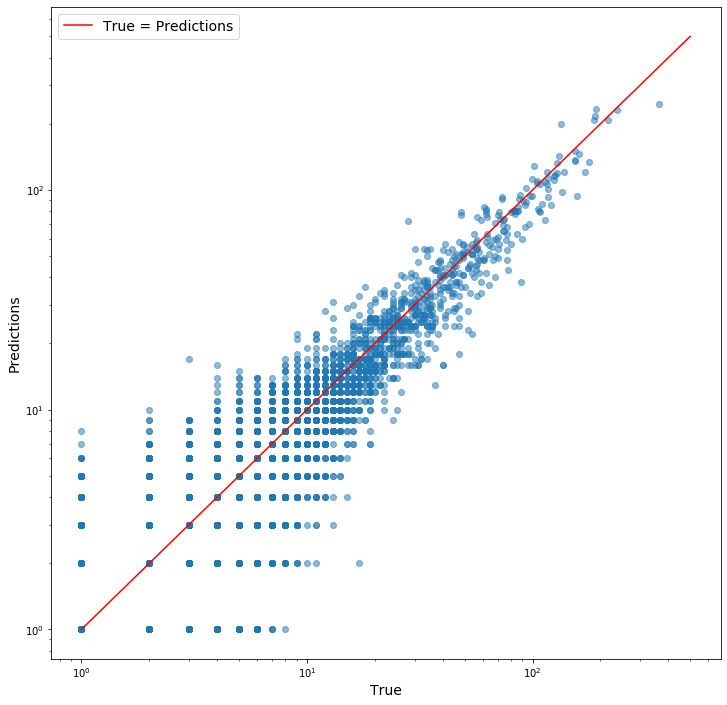

In [84]:
with PdfPages('pred_vs_true_sample_all.pdf') as pdf:
    fig = plt.figure(figsize=(12,12))
    ax3 = fig.add_subplot(111)
    plot_df = occpn_sample#sat_df
    ax3.scatter(plot_df['Number of Sats'], plot_df['Sat predicted'],
                alpha=0.5, rasterized=True)
    x = np.linspace(1.,500.,1000)
    ax3.plot(x, x, 'r', label = 'True = Predictions')
    ax3.set_xscale('log')
    ax3.set_yscale('log')
    ax3.legend(fontsize=14)
    ax3.set_ylabel('Predictions', fontsize=14)
    ax3.set_xlabel('True', fontsize=14)
    pdf.savefig()

## Calculating number of halos in a given mass and number of satellites in a halo of given mass

In [405]:
df = halo_combined_sort.copy()
#df['Sat predicted corr (top 5,0.1,20,5,1.0)'] = np.where(df['Sat predicted (top 5,0.1,20,5,1.0)'] < 0., 0, 
#         df['Sat predicted (top 5,0.1,20,5,1.0)'])
df['log10mvir'] = np.log10(df['mvir'])
bins = np.arange(0.,5.6,0.2)
df['Mass bins'] = pd.cut(df['log10mvir'],bins = bins, right=True)
df_sort = df.sort_values(by = 'Mass bins')
df_sort = index_reset_drop(df_sort)
sat_arr = np.zeros((len(df_sort['Mass bins'].value_counts().index.values),5))
cen_arr = np.zeros_like(sat_arr)
both_s_arr = np.zeros_like(sat_arr)

k = 0
for i in df_sort['Mass bins'].value_counts().index.values:
    df_cut = df_sort[df_sort['Mass bins'] == i]
    df_cut = index_reset_drop(df_cut)
    true_s = 'Number of Sats'
    pred_s = 'Sat predicted (all,0.02,10,1,1.0)'
    sat_arr[k,0] = np.mean(df_cut[true_s])
    sat_arr[k,1] = np.mean(df_cut[pred_s])
    sat_arr[k,2] = (i.right + i.left)/2.
    sat_arr[k,3] = np.std(df_cut[true_s])/np.sqrt(df_cut.shape[0])
    sat_arr[k,4] = np.std(df_cut[pred_s])/np.sqrt(df_cut.shape[0])

    true_c = 'Central Occupation (True)'
    pred_c = 'Cent predicted (top+env,0.02,20,10,1.0)'
    cen_arr[k,0] = np.mean(df_cut[true_c])
    cen_arr[k,1] = np.mean(df_cut[pred_c])
    cen_arr[k,2] = sat_arr[k,2]
    cen_arr[k,3] = np.std(df_cut[true_c])/np.sqrt(df_cut.shape[0])
    cen_arr[k,4] = np.std(df_cut[pred_c])/np.sqrt(df_cut.shape[0])

    both_s_arr[k,0] = np.mean(df_cut[true_s]+df_cut[true_c])
    both_s_arr[k,1] = np.mean(df_cut[pred_s]+df_cut[pred_c])
    both_s_arr[k,2] = sat_arr[k,2]
    both_s_arr[k,3] = np.std(df_cut[true_s]+df_cut[true_c])/np.sqrt(df_cut.shape[0])
    both_s_arr[k,4] = np.std(df_cut[pred_s]+df_cut[pred_c])/np.sqrt(df_cut.shape[0])

    k += 1

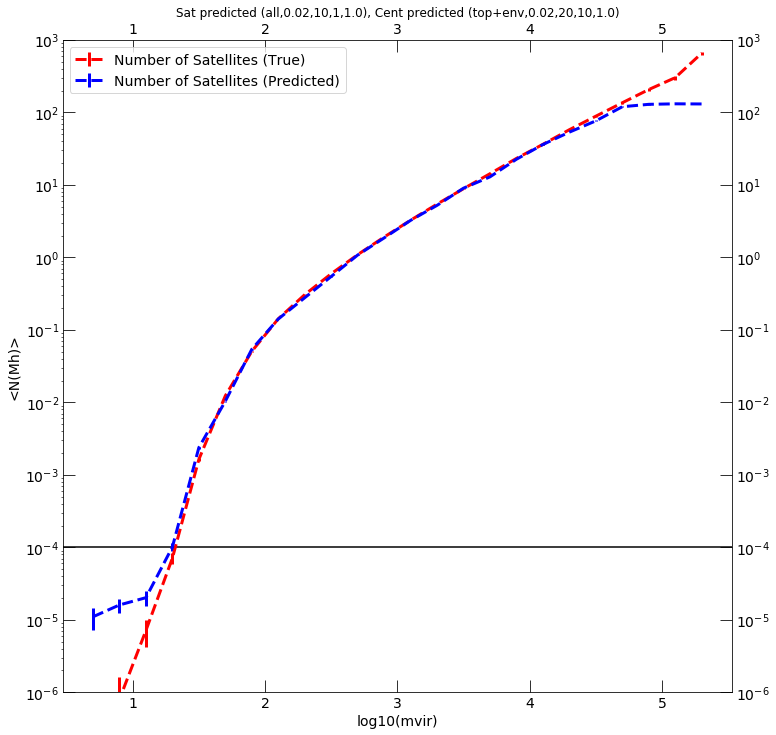

In [413]:
with PdfPages('avg_no_sat_all_01_10_1_cut.pdf') as pdf:
    indices = np.argsort(sat_arr[:,2])
    fig = plt.figure(figsize=(12,12))
    ax2 = fig.add_subplot(111)
    ax2.set_ylim(1E-6,1000)
    ax2.set_yscale('log')
    ax2.errorbar(sat_arr[indices,2],sat_arr[indices,0]
                 ,yerr=sat_arr[indices,3]
                 ,fmt='r--', lw=3, label = 'Number of Satellites (True)')
    ax2.errorbar(sat_arr[indices,2],sat_arr[indices,1],
                 yerr=sat_arr[indices,4],
                 fmt='b--', lw=3, label = 'Number of Satellites (Predicted)')
#    ax2.errorbar(cen_arr[indices,2],cen_arr[indices,0]
#                 ,yerr=cen_arr[indices,3]
#                 ,fmt='yo', label = 'Central Occupation (True)')
#    ax2.errorbar(cen_arr[indices,2],cen_arr[indices,1]
#                 ,yerr=cen_arr[indices,4]
#                 ,fmt='mo', label = 'Central Occupation (Predicted)')
#    ax2.errorbar(both_s_arr[indices,2],both_s_arr[indices,0]
#                 ,yerr=both_s_arr[indices,3]
#                 ,fmt='k-.' ,lw=3, label = 'Central and Satellites (True)')
#    ax2.errorbar(both_s_arr[indices,2],both_s_arr[indices,1]
#                 ,yerr=both_s_arr[indices,4]
#                 ,fmt='g-.' ,lw=3, label = 'Central and Satellites (Predicted)')
    ax2.legend(fontsize=14)
    ax2.set_xlabel('log10(mvir)',fontsize=14)
    ax2.set_ylabel('<N(Mh)>',fontsize=14)
    ax2.tick_params(axis = 'x', direction = 'in', top = True, size=12, labelsize=14, labeltop=True)
    ax2.tick_params(axis = 'y', direction = 'in', right = True, size=12, labelsize=14, labelright=True)
    ax2.set_title(pred_s + ', ' + pred_c)
    ax2.axhline(y=1E-4, xmin=0, xmax=6,color='k')
    pdf.savefig()

In [ ]:
df = halo_combined_final.copy()
N_sat = 1
df_true = df.loc[(df['Number of Satellites (True)'] == N_sat )]
df_true = index_reset_drop(df_true)
df_pred = df.loc[(df['Number of Satellites (Predicted, top 5, 1.0)'] == N_sat )]
df_pred = index_reset_drop(df_pred)

N = 50
bins = np.zeros(N+1)
bins[1:] = 10**np.linspace(0,6,N)
labels = np.linspace(0,6,N)
df_true['Sats Categories (True)'] = pd.cut(df_true['mvir'],
                               bins = bins, labels=labels,right=True)
df_pred['Sats Categories (Predicted)'] = pd.cut(df_pred['mvir'],
                               bins = bins, labels=labels,right=True)

with PdfPages('mvir_dist_nsat_' + str(N_sat) + '.pdf') as pdf:
    col = df_true['Sats Categories (True)'].value_counts()
    xvals = np.asarray(col.index.values)
    yvals = np.asarray(col)
    ind = np.argsort(xvals)
    xvals = xvals[ind]
    yvals = yvals[ind]
    plt.bar(xvals, yvals/np.sum(yvals),width=0.12,label='True')

    col = df_pred['Sats Categories (Predicted)'].value_counts()
    xvals = np.asarray(col.index.values)
    yvals = np.asarray(col)
    ind = np.argsort(xvals)
    xvals = xvals[ind]
    yvals = yvals[ind]
    plt.bar(xvals, yvals/np.sum(yvals),alpha=0.7,width=0.12,label='Predicted')
    
    plt.xlabel('log10(mvir)', fontsize=12)
    plt.ylabel('Fractional occurence', fontsize=12)
    plt.title(r'm_{vir} categories in satellite stratified samples', fontsize=12);
    plt.xlim(0.,4.)
    plt.legend()
    pdf.savefig()

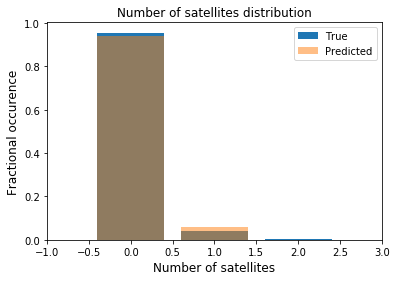

In [253]:
df = halo_combined_final.copy()
df['log10mvir'] = np.log10(halo_combined_final['mvir'])
ulim = 2.5
llim = 1.0
df = df.loc[(df['log10mvir'] <= ulim ) & (df['log10mvir'] >= llim )]
df = index_reset_drop(df)

bins = np.arange(0,np.max(df['Number of Satellites (True)']),1)
labels = bins[:-1]
df['Sats Categories (True)'] = pd.cut(df['Number of Satellites (True)'],
                               bins = bins, labels=labels,right=False)

df['Sats Categories (Predicted)'] = pd.cut(df['Number of Satellites (Predicted, top 5, 1.0)'],
                               bins = bins, labels=labels,right=False)

with PdfPages('nsats_dist_' + str(llim) + '_' + str(ulim) + '.pdf') as pdf:
    col = df['Sats Categories (True)'].value_counts()
    xvals = np.asarray(col.index.values)
    yvals = np.asarray(col)
    ind = np.argsort(xvals)
    xvals = xvals[ind]
    yvals = yvals[ind]
    plt.bar(xvals, yvals/np.sum(yvals),label='True')
    
    col = df['Sats Categories (Predicted)'].value_counts()
    xvals = np.asarray(col.index.values)
    yvals = np.asarray(col)
    ind = np.argsort(xvals)
    xvals = xvals[ind]
    yvals = yvals[ind]
    plt.bar(xvals, yvals/np.sum(yvals),label='Predicted', alpha=0.5)
    plt.xlabel('Number of satellites', fontsize=12)
    plt.ylabel('Fractional occurence', fontsize=12)
    plt.legend()
    plt.xlim(-1,3)
    plt.title(r'Number of satellites distribution', fontsize=12);
    pdf.savefig()

In [206]:
halo_combined_final.to_csv('full.txt', header=None, index=None, sep=',')

# APPENDIX

In [214]:
preds = pd.read_csv('satellite_80pct_test_all_pred.txt')

In [215]:
preds.columns

Index(['fofID', 'Number of Satellites (True)', 'Sats Categories',
       'Sat predicted (all,0.89,20,1,300,1)',
       'Sat predicted (all,0.89,20,1,300,14)',
       'Sat predicted (all,0.89,20,1,300,64)',
       'Sat predicted (all,0.89,20,1,300,799)',
       'Sat predicted (all,0.89,20,1,300,5152)',
       'Sat predicted (all,0.89,20,1,300,59066)',
       'Sat predicted (all,0.89,20,1,300,274581)',
       'Sat predicted (all,0.89,20,1,300,3875772)',
       'Sat predicted (all,0.89,20,1,300,32754311)',
       'Sat predicted (all,0.89,20,1,300,136132799)'],
      dtype='object')

In [216]:
true = preds['Number of Satellites (True)']

In [217]:
pred = preds['Sat predicted (all,0.89,20,1,300,1)']
print('Satellite fraction predicted = ', 
      (1.0 - (np.sum(pred)/np.sum(true)))*100, 'percent')

Satellite fraction predicted =  0.07349581868383304 percent


(-40.0, 40.0)

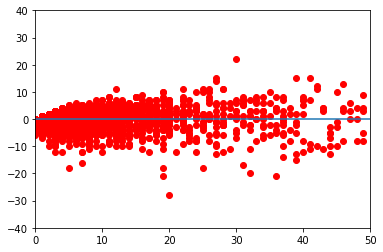

In [189]:
res = (pred - true)
res_mean = np.mean(res)
res_std = np.std(res)
z_res = (res - res_mean)/res_
plt.scatter(pred, ,c='red')
plt.hlines(0,0,300)
plt.xlim(0,50)
plt.ylim(-40,40)

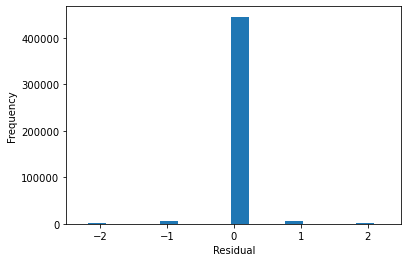

In [199]:
plt.hist(pred-true,bins=1000)
plt.xlim(-2.5,2.5)
plt.xlabel('Residual')
plt.ylabel('Frequency');

In [204]:
res = np.array(pred - true)

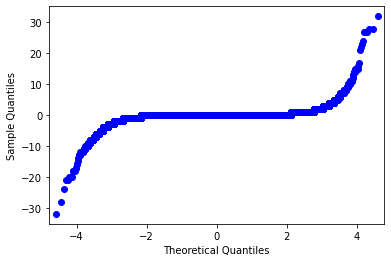

In [206]:
fig = sm.qqplot(res[res > -50], stats.norm)
plt.show()

Mean of r^2 scroes from RF Regression, max_features =  log2 , Uncorrelated features =  0.932 , Std. Dev. =  0.011
Mean of adjusted r^2 scores from RF Regression, max_features =  log2 , Uncorrelated features =  0.869 , Std. Dev. =  0.020
Total r^2 score RF =  0.892
Total adjusted r^2 score RF =  0.795
Test r^2 score RF =  0.885
Test adjusted r^2 score RF =  0.783
time =   2 minutes
**********
Mean of r^2 scroes from RF Regression, max_features =  1.0 , Uncorrelated features =  0.934 , Std. Dev. =  0.007
Mean of adjusted r^2 scores from RF Regression, max_features =  1.0 , Uncorrelated features =  0.873 , Std. Dev. =  0.014
Total r^2 score RF =  0.898
Total adjusted r^2 score RF =  0.807
Test r^2 score RF =  0.892
Test adjusted r^2 score RF =  0.795
time =   5 minutes
**********


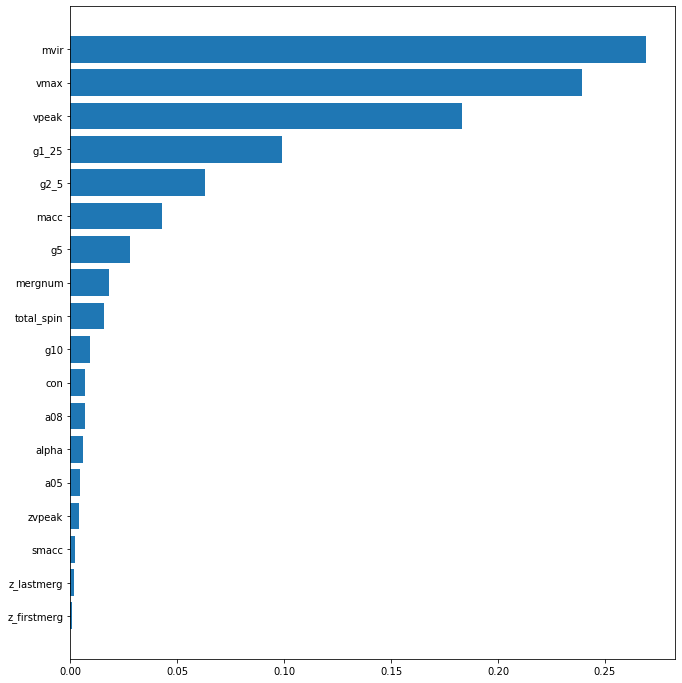

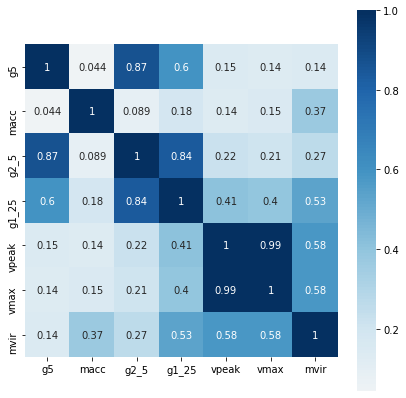

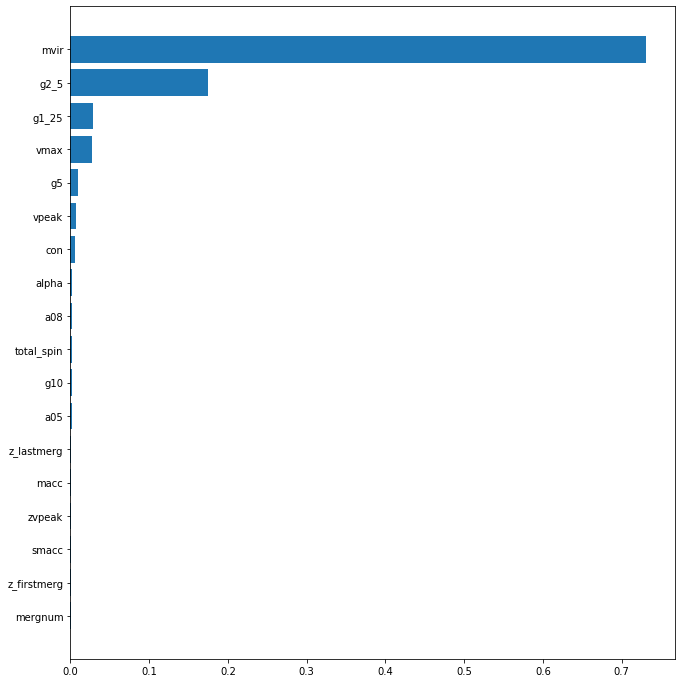

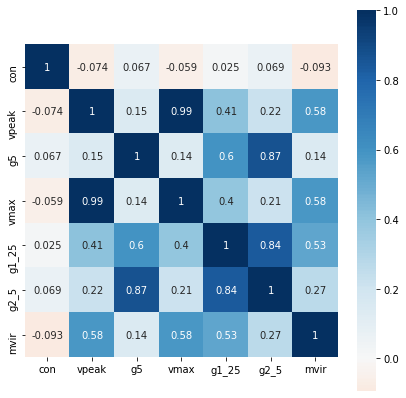

In [42]:
halo_features_all =  ['con','mvir','vmax','a05','a08','vpeak',
'zvpeak','macc','smacc','mergnum','z_firstmerg','z_lastmerg',
'total_spin','g1_25','g2_5','g5','g10','alpha']

feature_uncorr_reg = [['mvir','vmax','g1_25','g2_5','macc'],
                      ['mvir','g2_5','g1_25','vmax','con']]

#halo_features_halo =  ['con','mvir','vmax','a05','a08','vpeak',
#'zvpeak','macc','smacc','mergnum','z_firstmerg','z_lastmerg',
#'total_spin','alpha']

#feature_uncorr_reg = [['mvir','vmax','alpha','macc'],
#                      ['mvir','con','total_spin','alpha']]

grid = ['log2', 1.0]
#grid = [1.0]
#feature_uncorr_reg = [['con','g2_5','mvir']]
halo_sample_shuffle = strat_train_set.copy()
y = halo_sample_shuffle['Number of Sats'].to_numpy()

for i in range(len(grid)):
    start = time.time()
    # Step 1: Training with all features and find the most important ones
    X = halo_sample_shuffle[halo_features_all]
    #X = halo_sample_shuffle[halo_features_halo]
    X_train, X_val, y_train, y_val = train_test_split(X, y, random_state = random_state[0])
    rfreg = RandomForestRegressor(n_estimators = 100, 
                max_depth = 20.0,min_samples_leaf = 5,
                n_jobs = -1,oob_score = False,random_state = random_state[0],
                max_features=grid[i])
    rfreg.fit(X_train, y_train);
    outfile = 'feature_full_sat_' + str(grid[i]) + '.pdf'
    bar_plot(rfreg,X_train.columns,outfile)

    feature_imp = rfreg.feature_importances_
    features_arr = np.array(X_train.columns)

    indices = np.argsort(feature_imp)

    feature_pos = np.hstack((indices[-7:-1],indices[-1]))
    halo_features_top = features_arr[feature_pos]

    # Step 2: Plotting correlation matrix/heatmap of top 7 features 
    X = halo_sample_shuffle[halo_features_top]
    outfile = 'heatmap_sat_' + str(grid[i]) + '.pdf'
    corr_mat(X.corr(),outfile)

    # Step 3: Predictions from top 3-4 least correlated features
    X = halo_sample_shuffle[feature_uncorr_reg[i]]
    X_train, X_val, y_train, y_val = train_test_split(X, y, random_state = random_state[0])

    rfreg.fit(X_train, y_train); 
    rfreg_uncorr_scores = cross_val_score(rfreg, X, y, scoring="r2", cv=5)
    print('Mean of r^2 scroes from RF Regression,', 'max_features = ', grid[i], 
          ', Uncorrelated features = ', '{:0.3f}'.format(np.mean(rfreg_uncorr_scores)),
          ', Std. Dev. = ', '{:0.3f}'.format(np.std(rfreg_uncorr_scores)))  
    
    print('Mean of adjusted r^2 scores from RF Regression,', 'max_features = ', grid[i], 
          ', Uncorrelated features = ', 
          '{:0.3f}'.format(np.mean(adj_r2(rfreg_uncorr_scores,len(X),len(feature_uncorr_reg[i])))),
          ', Std. Dev. = ', 
          '{:0.3f}'.format(np.std(adj_r2(rfreg_uncorr_scores,len(X),len(feature_uncorr_reg[i])))))  

    X_total = halo_combined[feature_uncorr_reg[i]]
    pred_total = rfreg.predict(X_total)
    true_total = halo_combined['Number of Sats']
    print('Total r^2 score RF = ', '{:0.3f}'.format(r2_score(true_total,pred_total)))
    print('Total adjusted r^2 score RF = ', '{:0.3f}'.format(adj_r2(r2_score(true_total,pred_total),
                                                           len(true_total),len(feature_uncorr_reg[i]))))

    strat_test = strat_test_set[feature_uncorr_reg[i]]
    pred_test = rfreg.predict(strat_test)
    true_test = strat_test_set['Number of Sats']    
    print('Test r^2 score RF = ', '{:0.3f}'.format(r2_score(true_test,pred_test)))
    print('Test adjusted r^2 score RF = ', '{:0.3f}'.format(adj_r2(r2_score(true_test,pred_test),
                                                           len(true_test),len(feature_uncorr_reg[i]))))

    end = time.time()
    print('time = ','{:2.0f}'.format((end - start)/60.),'minutes')
    print('**********')

# Making a pd column that contains predictions

#halo_combined['Sat predicted'] = pred_total

In [338]:
unique,counts=np.unique(pred_train,return_counts=True)
ind = np.argsort(pred_train)
errors = np.zeros_like(unique)
avg = np.zeros_like(unique)
b_start = 0
sigma = np.zeros_like(pred_train)

for a in range(len(unique)):
    c = counts[a]
    true = np.zeros(c)
    pred = np.zeros(c)
    for b in range(b_start, c+b_start):
        true[b-b_start] = y_train[ind[b]]
        pred[b-b_start] = pred_train[ind[b]]
    errors[a] = mse(true,pred) 
    avg[a] = np.mean(true)
    sigma[ind[b_start:b]] = np.sqrt(errors[a])
    b_start = b+1

In [330]:
estimator = gbreg.estimators_[0,0]
export_graphviz(estimator, out_file='gbreg_0.dot', 
                rounded = True, proportion = False, 
                precision = 2, filled = True)
#tree.export_graphviz(rfreg, out_file='tree.dot', 
#                rounded = True, proportion = False, 
#                precision = 2, filled = True)

## Trying PCA to reduce number of features

##### Using PCA did not work!

In [25]:
df = halo_combined_sort[halo_features_all].copy()
df_scale = df.copy()
df_scale[halo_features_all] = scaler.fit_transform(df[halo_features_all])
df_scale['Sats Categories'] = halo_combined_sort['Sats Categories'] 
df_scale['Number of Sats'] = halo_combined_sort['Number of Sats'] 
df = df_scale

for train_index, test_index in split.split(df,df['Sats Categories']):
    strat_train_set = df.loc[train_index]
    strat_test_set = df.loc[test_index]
strat_train_set = index_reset_drop(strat_train_set)
strat_test_set = index_reset_drop(strat_test_set)

In [26]:
from sklearn.decomposition import PCA

halo_sample_shuffle = strat_train_set.copy()
X_scale = halo_sample_shuffle[halo_features_all]

pca = PCA(n_components=4)

In [27]:
X_red = pca.fit_transform(X_scale)
y = halo_sample_shuffle['Number of Sats']

In [28]:
X_train, X_val, y_train, y_val = train_test_split(X_red, y, random_state = 0)
rfreg = RandomForestRegressor(n_estimators = 100, 
                max_depth = 20.0,min_samples_leaf = 5,
                n_jobs = -1,oob_score = False,random_state = 0,
                max_features=grid[1])
rfreg.fit(X_train, y_train);


In [29]:
start = time.time()
rfreg_uncorr_scores = cross_val_score(rfreg, X_red, y, scoring="r2", cv=5)
print(rfreg_uncorr_scores)
print('mean = ', np.mean(rfreg_uncorr_scores),
      'std dev = ',np.std(rfreg_uncorr_scores))
end = time.time()
print('time = ', (end - start)/60.,'minutes')

[0.70280842 0.80643388 0.85154305 0.83690031 0.8062752 ]
mean =  0.8007921717836105 std dev =  0.05204259220439257
time =  3.1521540522575378 minutes


In [30]:
X_scale = df_scale[halo_features_all].copy()
X_red = pca.transform(X_scale)
pred_total = rfreg.predict(X_red)
true_total = halo_combined_sort['Number of Sats']
print(r2_score(true_total,pred_total))

0.7822242874436816


##### Using PCA did not work!

In [484]:
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

poly_kernal_svm_clf = Pipeline([("scaler",StandardScaler()),
                                ("svm_clf",SVC(kernel="poly", degree=3,
                                              coef0=1, C=10))])
poly_kernal_svm_clf.fit(X_train, y_train)
print(f1_score(y_train,pred_train))
print(f2_score(y_train,pred_train))
pred_val = poly_kernal_svm_clf.predict(X_val)
print(f1_score(y_val,pred_val))
print(f2_score(y_val,pred_val))

pred_total = poly_kernal_svm_clf.predict(X_total)
print(f1_score(true_total,pred_total))
print(f2_score(true_total,pred_total))


0.9062145182045267
0.9181826548455378
0.8944155550531313
0.9085898024804777
0.9037613247864646
0.9172461185119086


In [113]:
def conserve_n_density(X_total,rfclass,pred_total,true_total,outfile):
    zeros = 8022062
    ones = 745150
    X_proba = rfclass.predict_proba(X_total)
    X_ind = np.argsort(X_proba[:,1])[::-1]
    pred_total_desc = pred_total[X_ind]
    pred_total_desc[ones:] = 0
    X_ind_ind = np.argsort(X_ind)
    pred_total_back = pred_total_desc[X_ind_ind]
    cm_cent_uncorr = confusion_matrix(true_total, pred_total_back)
    plot_conf_matrix(cm_cent_uncorr,outfile)
    print('F1 = F2 = ', f1_score(true_total,pred_total_back))
    return pred_total_back


F1 = F2 =  0.8980728712339797


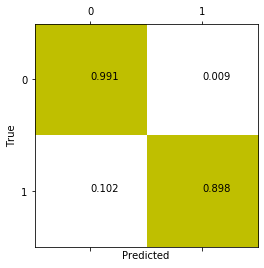

In [473]:
outfile = 'confusion_uncorr_' + str(grid[i]) + 'n_dens.pdf'
pred_total_back = conserve_n_density(X_total,gbclass,pred_total,true_total,outfile)
#cent_data_cp['Cent predicted, ' + str(grid[i])] = pred_total 
#cent_data_cp['Cent predicted, ' + str(grid[i]) + ', n_density'] = pred_total_back 

### Adding environment for centrals

F1 score =  0.906
F2 score =  0.920
Number of Centrals predicted are off by =  -5.4 percent


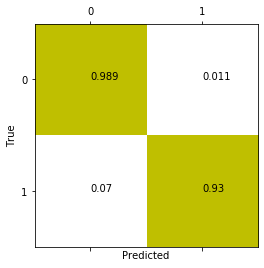

In [685]:
environ_feat = [['vmax','mvir','total_spin','z_firstmerg','macc','g1_25'],
                ['vmax','z_lastmerg','total_spin','a05','g1_25']]
X = central_both_shuffle[environ_feat[i]]
y = central_both_shuffle['stellarMass'].to_numpy()

#rfclass = RandomForestClassifier(n_estimators = 200, 
#            max_depth = 20.0,min_samples_leaf = 10,
#            n_jobs = -1,oob_score = False,random_state = random_state[0],
#            max_features=grid[i])
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state = random_state[0])
rfclass.fit(X_train, y_train);

#pred_rf_uncorr = rfclass.predict(X_val)
#cm_cent_uncorr = confusion_matrix(y_val, pred_rf_uncorr)
#outfile = 'confusion_uncorr_environ_' + str(1.0) + '.pdf'
#plot_conf_matrix(cm_cent_uncorr,outfile)

X_total = cent_data_cp[environ_feat[i]]
pred_total = rfclass.predict(X_total)
true_total = cent_data_cp['stellarMass']
print('F1 score = ', '{:0.3f}'.format(f1_score(true_total,pred_total)))
print('F2 score = ', '{:0.3f}'.format(f2_score(true_total,pred_total)))
cm_cent_uncorr = confusion_matrix(true_total, pred_total)
outfile = 'confusion_uncorr_environ_' + str(grid[i]) + '.pdf'
plot_conf_matrix(cm_cent_uncorr,outfile)

#cent_data_cp['Cent predicted from environment, ' + str(grid[i])] = pred_total
print('Number of Centrals predicted are off by = ', 
      '{:1.2}'.format((1. - (np.sum(pred_total)/np.sum(true_total)))*100), 'percent')

In [686]:
pred_total_adj = pred_total.copy()
X_proba = rfclass.predict_proba(X_total)
for l in range(len(pred_total)):
    prob = X_proba[l,1]
    if (np.random.uniform(0.,1.) < prob):
        pred_total_adj[l] = 1
    else:
        pred_total_adj[l] = 0
print('True split: ', Counter(true_total))        
print('Predicted split WITHOUT probability: ', Counter(pred_total))    
print('Predicted split USING probability: ', Counter(pred_total_adj))    
#print('F1 score = ', f1_score(true_total,pred_total_adj))
#print('F2 score = ', f2_score(true_total,pred_total_adj))
print('Number of Centrals predicted are off by = ', 
      '{:1.2}'.format((1. - (np.sum(pred_total_adj)/np.sum(true_total)))*100), 'percent')
cent_data_cp['Cent predicted, top5+env, ' + str(grid[i])] = pred_total_adj        

#cm_cent = confusion_matrix(true_total, pred_total_adj)
#plot_conf_matrix(cm_cent,'temp.pdf')

True split:  Counter({0: 8022062, 1: 745150})
Predicted split WITHOUT probability:  Counter({0: 7981915, 1: 785297})
Predicted split USING probability:  Counter({0: 8021736, 1: 745476})
Number of Centrals predicted are off by =  -0.044 percent


In [166]:
outfile = 'confusion_uncorr_environ_' + str(grid[i]) + 'n_dens.pdf'
pred_total_back = conserve_n_density(X_total,rfclass,pred_total,true_total,outfile)
cent_data_cp['Cent predicted, top5+env, ' + str(grid[i])] = pred_total 
cent_data_cp['Cent predicted, top5+env, ' + str(grid[i]) + ', n_density'] = pred_total_back 

IndexError: list index out of range

### Adding all halo features

F1 score =  0.913
F2 score =  0.928
Number of Centrals predicted are off by =  -5.5 percent


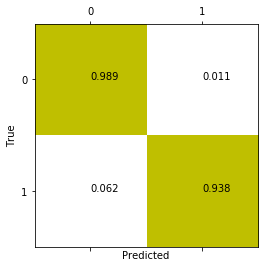

In [687]:
X = central_both_shuffle[halo_features_all]
y = central_both_shuffle['stellarMass'].to_numpy()

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state = random_state[0])
rfclass.fit(X_train, y_train);

#pred_rf_uncorr = rfclass.predict(X_val)
#cm_cent_uncorr = confusion_matrix(y_val, pred_rf_uncorr)
#outfile = 'confusion_uncorr_all_' + str(grid[i]) + '.pdf'
#plot_conf_matrix(cm_cent_uncorr,outfile)

X_total = cent_data_cp[halo_features_all]
pred_total = rfclass.predict(X_total)
true_total = cent_data_cp['stellarMass']

cm_cent_uncorr = confusion_matrix(true_total, pred_total)
outfile = 'confusion_uncorr_all_' + str(grid[i]) + '.pdf'
plot_conf_matrix(cm_cent_uncorr,outfile)

print('F1 score = ','{:0.3f}'.format(f1_score(true_total,pred_total)))
print('F2 score = ','{:0.3f}'.format(f2_score(true_total,pred_total)))

#cent_data_cp['Cent predicted from all'] = pred_total
print('Number of Centrals predicted are off by = ', 
      '{:1.2}'.format((1. - (np.sum(pred_total)/np.sum(true_total)))*100), 'percent')

In [688]:
pred_total_adj = pred_total.copy()
X_proba = rfclass.predict_proba(X_total)
for l in range(len(pred_total)):
    prob = X_proba[l,1]
    if (np.random.uniform(0.,1.) < prob):
        pred_total_adj[l] = 1
    else:
        pred_total_adj[l] = 0
print('True split: ', Counter(true_total))        
print('Predicted split WITHOUT probability: ', Counter(pred_total))    
print('Predicted split USING probability: ', Counter(pred_total_adj))    
#print('F1 score = ', f1_score(true_total,pred_total_adj))
#print('F2 score = ', f2_score(true_total,pred_total_adj))
print('Number of Centrals predicted are off by = ', 
      '{:1.2}'.format((1. - (np.sum(pred_total_adj)/np.sum(true_total)))*100), 'percent')
cent_data_cp['Cent predicted, all, ' + str(grid[i])] = pred_total_adj        

#cm_cent = confusion_matrix(true_total, pred_total_adj)
#plot_conf_matrix(cm_cent,'temp.pdf')

True split:  Counter({0: 8022062, 1: 745150})
Predicted split WITHOUT probability:  Counter({0: 7980740, 1: 786472})
Predicted split USING probability:  Counter({0: 8020551, 1: 746661})
Number of Centrals predicted are off by =  -0.2 percent


F1 = F2 =  0.9159122324364222


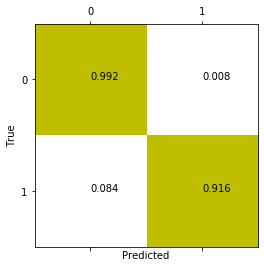

In [121]:
outfile = 'confusion_uncorr_all_' + str(grid[i]) + 'n_dens.pdf'
pred_total_back = conserve_n_density(X_total,rfclass,pred_total,true_total,outfile)
cent_data_cp['Cent predicted, all, ' + str(grid[i])] = pred_total 
cent_data_cp['Cent predicted, all, ' + str(grid[i]) + ', n_density'] = pred_total_back 

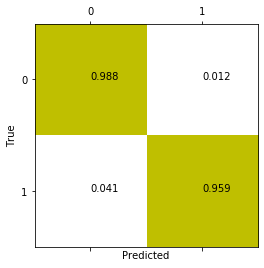

In [203]:
sm = SMOTE(random_state=42, sampling_strategy=0.2)
X_res, y_res = sm.fit_resample(X, y)
X_train, X_val, y_train, y_val = train_test_split(X_res, y_res, random_state = random_state[0])
rfclass.fit(X_train, y_train);
pred_total = rfclass.predict(X_total)
cm_cent_uncorr = confusion_matrix(true_total, pred_total)
plot_conf_matrix(cm_cent_uncorr,'temp.pdf')
print('f1 = ', f1_score(true_total, pred_total))
print('f2 = ', f2_score(true_total, pred_total))

(500.0, 1000.0)

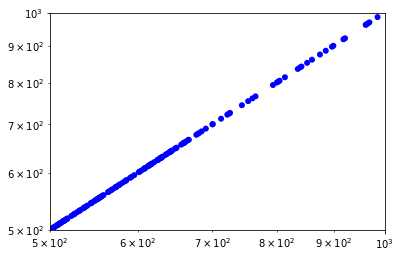

In [440]:
halo_sample_cp = central_both_shuffle.copy()
col = np.where(halo_sample_cp['stellarMass'] == 0, 'r', 'b')

plt.scatter(halo_sample_cp['vmax'], 
            halo_sample_cp['vmax'], c = col,
            linewidth=0)
plt.yscale('log')
plt.xscale('log')
plt.xlim(500., 1000.0);
plt.ylim(500., 1000.0)


In [416]:
cent_data_cut = cent_data_cp.loc[((cent_data_cp.vmax < 250) & (cent_data_cp.vmax > 120))]
halo_sample_cut = cent_data_cut.sample(frac=0.1/6., random_state = random_state[0])
halo_sample_cut = index_reset_drop(halo_sample_cut)

X = halo_sample_cut[halo_features_all]
#X = halo_sample_cut[['vpeak','g1_25','macc','smacc','g10']]
y = halo_sample_cut['stellarMass']
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state = random_state[0])

rfclass = RandomForestClassifier(n_estimators = 200, 
            max_depth = 5.0,
            n_jobs = -1,oob_score = False,
            random_state = random_state[0],max_features=1.0)
rfclass.fit(X_train, y_train);

pred_val = rfclass.predict(X_val)
print(f1_score(y_val,pred_val))
print(f2_score(y_val,pred_val)) 

#X = cent_data_cut[halo_features_all]
#X = cent_data_cut[['vpeak','g1_25','macc','smacc','g10']]
#pred_rf = rfclass.predict(X)
#true_cut = cent_data_cut.stellarMass
#print('{:0.3f}'.format(f1_score(true_cut,pred_rf)))
#print('{:0.3f}'.format(f2_score(true_cut,pred_rf)))

0.8854027166634781
0.9003891050583658


In [415]:
pred_rf = cent_data_cut['Cent predicted, 1.0']
print('{:0.3f}'.format(f1_score(true_cut,pred_rf)))
print('{:0.3f}'.format(f2_score(true_cut,pred_rf)))

0.886
0.902


In [133]:
bins = np.zeros(8)
bins[1:] = 10**np.linspace(0,6,7)
labels = np.linspace(0,6,7)

halo_combined_sort['Cent-Sats Categories'] = pd.cut(halo_combined_sort['mvir'],
                                        bins = bins, labels=labels,right=True)
halo_combined_shuffle = halo_combined_sort.sample(frac=1).reset_index(drop=True)

In [134]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.9, random_state=10)

df = halo_combined_shuffle
for train_index, test_index in split.split(df,df['Cent-Sats Categories']):
    strat_train_set = df.loc[train_index]
    strat_test_set = df.loc[test_index]
strat_train_set = index_reset_drop(strat_train_set)
strat_test_set = index_reset_drop(strat_test_set)

In [135]:
grid = [1.0]
feature_uncorr_reg = [['mvir','con','g2_5','g1_25']]
halo_sample_shuffle = strat_train_set.copy()
y = halo_sample_shuffle['Number of Sats'].to_numpy()

for i in range(len(grid)):
    start = time.time()
    X = pd.get_dummies(halo_sample_shuffle[halo_features_all])
    X1 = X.copy()
    X_train, X_val, y_train, y_val = train_test_split(X, y, random_state = 0)
    rfreg = RandomForestRegressor(n_estimators = 100, 
                max_depth = 20.0,min_samples_leaf = 5,
                n_jobs = -1,oob_score = False,random_state = 0,
                max_features=grid[i])
    rfreg.fit(X_train, y_train);
    #outfile = 'feature_full_cent_sat_' + str(grid[i]) + '.pdf'
    #bar_plot(rfreg,X_train.columns,outfile)

    feature_imp = rfreg.feature_importances_
    features_arr = np.array(X_train.columns)

    indices = np.argsort(feature_imp)

    feature_pos = np.hstack((indices[-7:-1],indices[-1]))
    halo_features_top = features_arr[feature_pos]

    X = pd.get_dummies(halo_sample_shuffle[halo_features_top])
    #outfile = 'heatmap_cent_sat_' + str(grid[i]) + '.pdf'
    #corr_mat(X.corr(),outfile)
       
    X = pd.get_dummies(halo_sample_shuffle[feature_uncorr_reg[i]])
    X_train, X_val, y_train, y_val = train_test_split(X, y, random_state = 0)

    rfreg.fit(X_train, y_train); 
    #rfreg_uncorr_scores = cross_val_score(rfreg, X, y, scoring="r2", cv=5)
    #print('Mean of RF Regression,', 'max_features = ', grid[i], 
    #      ', Uncorrelated features = ', '{:0.3f}'.format(np.mean(rfreg_uncorr_scores)),
    #      ', Std. Dev. = ', '{:0.3f}'.format(np.std(rfreg_uncorr_scores)))  
    
    X_total = halo_combined_shuffle[feature_uncorr_reg[i]]
    pred_total = rfreg.predict(X_total)
    true_total = halo_combined_shuffle['Number of Sats']
    print('Total r^2 score RF = ', '{:0.3f}'.format(r2_score(true_total,pred_total)))

    strat_test = strat_test_set[feature_uncorr_reg[i]]
    pred_test = rfreg.predict(strat_test)
    true_test = strat_test_set['Number of Sats']
    print('Test r^2 score RF = ', '{:0.3f}'.format(r2_score(true_test,pred_test)))

    end = time.time()
    print('time = ','{:2.0f}'.format((end - start)/60.),'minutes')
    print('**********')
    
halo_combined_shuffle['Cent+Sat predicted'] = pred_total

Total r^2 score RF =  0.883
Test r^2 score RF =  0.895
time =   3 minutes
**********


In [39]:
#halo_combined_shuffle['Cent+Sat predicted Rounded Off'] = np.rint(halo_combined_shuffle['Cent+Sat predicted'])

In [136]:
pred_total_adj = pred_total.copy()
for i in range(len(pred_total)):
    if (pred_total[i] < 1. ):
        if (np.random.rand(1) < pred_total[i]):
            pred_total_adj[i] = 1.
        else:
            pred_total_adj[i] = 0.

In [137]:
halo_combined_shuffle['Cent+Sat predicted Rounded Off'] = pred_total_adj
halo_combined_shuffle['Cent+Sat predicted Rounded Off'] = np.rint(halo_combined_shuffle['Cent+Sat predicted Rounded Off'])

In [692]:
halo_combined_final = halo_combined_sort.copy()
halo_combined_final_sort = halo_combined_final.sort_values(by = 'fofID')
halo_combined_final_sort = index_reset_drop(halo_combined_final_sort)

df = halo_combined_final_sort.copy()
cols = np.hstack((df.columns[-8:-1],df.columns[-1]))
df = df.drop(columns=cols,axis=1) 

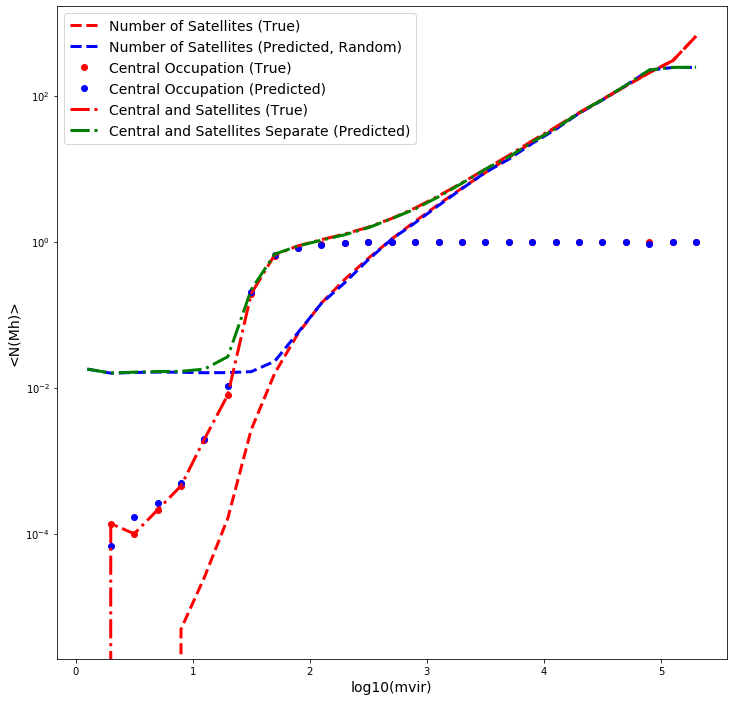

In [87]:
with PdfPages('avg_no_gb_random.pdf') as pdf:
    indices = np.argsort(sat_arr[:,2])
    fig = plt.figure(figsize=(12,12))
    ax2 = fig.add_subplot(111)
    #ax2.set_ylim(0.05,1000)
    ax2.semilogy(sat_arr[indices,2],sat_arr[indices,0],'r--',lw=3, label = 'Number of Satellites (True)')
    ax2.semilogy(sat_arr[indices,2],sat_arr[indices,1],'b--',lw=3, label = 'Number of Satellites (Predicted, Random)')
    ax2.semilogy(cen_arr[indices,2],cen_arr[indices,0],'ro', label = 'Central Occupation (True)')
    ax2.semilogy(cen_arr[indices,2],cen_arr[indices,1],'bo', label = 'Central Occupation (Predicted)')
    ax2.semilogy(both_s_arr[indices,2],both_s_arr[indices,0],'r-.',lw=3, label = 'Central and Satellites (True)')
    ax2.semilogy(both_s_arr[indices,2],both_s_arr[indices,1],'g-.',lw=3, label = 'Central and Satellites Separate (Predicted)')
    ax2.legend(fontsize=14)
    ax2.set_xlabel('log10(mvir)',fontsize=14)
    ax2.set_ylabel('<N(Mh)>',fontsize=14)
    pdf.savefig()

In [242]:
df = sat_df.copy()
df['log10mvir'] = np.log10(sat_df['mvir'])
bins = np.arange(0.,5.6,0.2)
df['Mass bins'] = pd.cut(df['log10mvir'],bins = bins, right=True)
df_sort = df.sort_values(by = 'Mass bins')
df_sort = index_reset_drop(df_sort)
sat_arr = np.zeros((len(df_sort['Mass bins'].value_counts().index.values),5))
cen_arr = np.zeros_like(sat_arr)
both_s_arr = np.zeros_like(sat_arr)

k = 0
for i in df_sort['Mass bins'].value_counts().index.values:
    df_cut = df_sort[df_sort['Mass bins'] == i]
    df_cut = index_reset_drop(df_cut)
    sat_arr[k,0] = np.mean(df_cut['Number of Sats'])
    sat_arr[k,1] = np.mean(df_cut['Sat predicted'])
    sat_arr[k,2] = (i.right + i.left)/2.
    sat_arr[k,3] = np.std(df_cut['Number of Sats'])
    sat_arr[k,4] = np.std(df_cut['Sat predicted'])

    cen_arr[k,0] = np.mean(df_cut['Central Occupation (True)'])
    cen_arr[k,1] = np.mean(df_cut['Central Occupation (Predicted)'])
    cen_arr[k,2] = sat_arr[k,2]
    cen_arr[k,3] = np.std(df_cut['Central Occupation (True)'])
    cen_arr[k,4] = np.std(df_cut['Central Occupation (Predicted)'])

    both_s_arr[k,0] = np.mean(df_cut['Central and Satellites (True)'])
    both_s_arr[k,1] = np.mean(df_cut['Central and Satellites (Predicted)'])
    both_s_arr[k,2] = sat_arr[k,2]
    both_s_arr[k,3] = np.std(df_cut['Central and Satellites (True)'])
    both_s_arr[k,4] = np.std(df_cut['Central and Satellites (Predicted)'])
   
    k += 1

/Users/saurabh/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':
/Users/saurabh/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in greater
  if sys.path[0] == '':


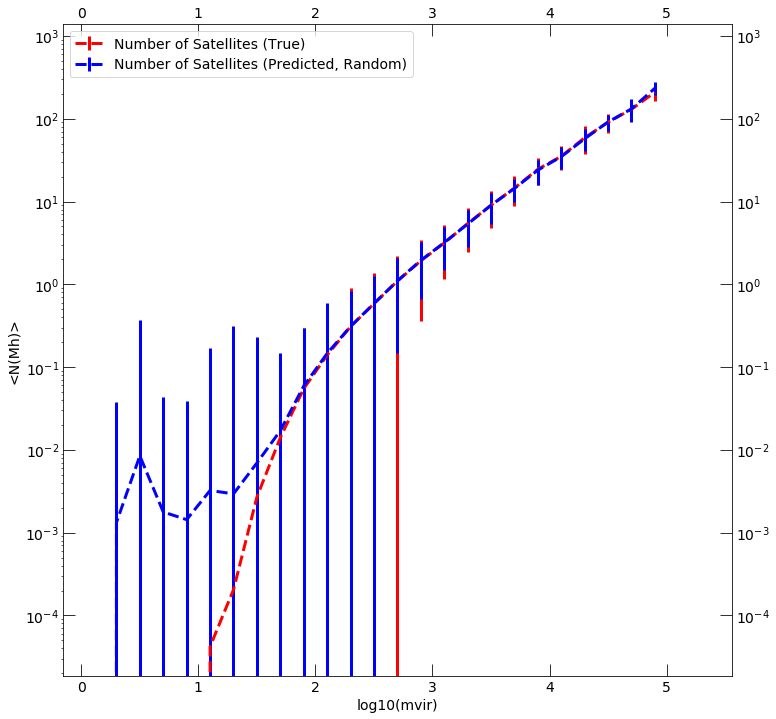

In [257]:
with PdfPages('sample_yerr.pdf') as pdf:
    indices = np.argsort(sat_arr[:,2])
    fig = plt.figure(figsize=(12,12))
    ax2 = fig.add_subplot(111)
    #ax2.set_ylim(0.05,1000)
    ax2.set_yscale('log')
    thres = 0.0
    ax2.errorbar(sat_arr[indices,2],sat_arr[indices,0]
                 ,yerr=np.where(sat_arr[indices,3]>thres,sat_arr[indices,3],0.0)
                 ,fmt='r--', lw=3, label = 'Number of Satellites (True)')
    ax2.errorbar(sat_arr[indices,2],sat_arr[indices,1],
                 yerr=np.where(sat_arr[indices,4]>thres,sat_arr[indices,4],0.0),
                 fmt='b--', lw=3, label = 'Number of Satellites (Predicted, Random)')
    #ax2.errorbar(cen_arr[indices,2],cen_arr[indices,0]
    #             ,yerr=np.where(cen_arr[indices,3]>thres,cen_arr[indices,3],0.0)
    #             ,fmt='yo', label = 'Central Occupation (True)')
    #ax2.errorbar(cen_arr[indices,2],cen_arr[indices,1]
    #             ,yerr=np.where(cen_arr[indices,4]>thres,cen_arr[indices,4],0.0)
    #             ,fmt='mo', label = 'Central Occupation (Predicted)')
    #ax2.errorbar(both_s_arr[indices,2],both_s_arr[indices,0]
    #             ,yerr=np.where(both_s_arr[indices,3]>thres,both_s_arr[indices,3],0.0)
    #             ,fmt='k-.' ,lw=3, label = 'Central and Satellites (True)')
    #ax2.errorbar(both_s_arr[indices,2],both_s_arr[indices,1]
    #             ,yerr=np.where(both_s_arr[indices,4]>thres,both_s_arr[indices,4],0.0)
    #             ,fmt='g-.' ,lw=3, label = 'Central and Satellites Separate (Predicted)')
    ax2.legend(fontsize=14)
    ax2.set_xlabel('log10(mvir)',fontsize=14)
    ax2.set_ylabel('<N(Mh)>',fontsize=14)
    ax2.tick_params(axis = 'x', direction = 'in', top = True, size=12, labelsize=14, labeltop=True)
    ax2.tick_params(axis = 'y', direction = 'in', right = True, size=12, labelsize=14, labelright=True)
    pdf.savefig()

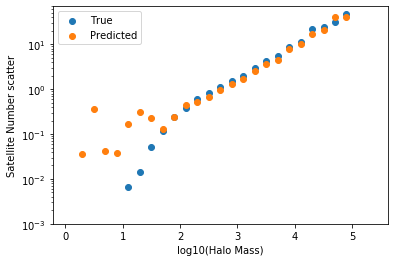

In [265]:
with PdfPages('sat_scatter.pdf') as pdf:
    plt.yscale('log')
    plt.ylim(1E-3,70)
    plt.scatter(sat_arr[indices,2],sat_arr[indices,3],label='True')
    plt.scatter(sat_arr[indices,2],sat_arr[indices,4],label='Predicted')
    plt.legend()
    plt.xlabel('log10(Halo Mass)')
    plt.ylabel('Satellite Number scatter')
    pdf.savefig()

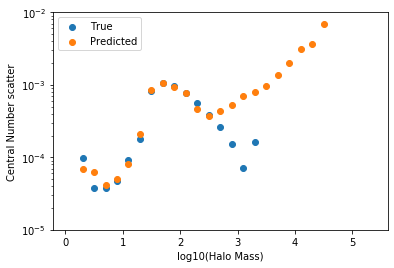

In [100]:
with PdfPages('cen_scatter.pdf') as pdf:
    plt.yscale('log')
    plt.ylim(1E-5,1E-2)
    #plt.xlim(0.5,3)
    plt.scatter(cen_arr[indices,2],cen_arr[indices,3],label='True')
    plt.scatter(cen_arr[indices,2],cen_arr[indices,4],label='Predicted')
    plt.legend()
    plt.xlabel('log10(Halo Mass)')
    plt.ylabel('Central Number scatter')
    pdf.savefig()


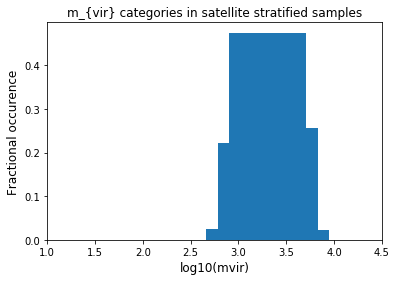

In [215]:
df = halo_combined_final.copy()
#df['log10mvir'] = np.log10(halo_combined_final['mvir'])
#df = df.loc[(df['log10mvir'] <= 3 ) & (df['log10mvir'] >= 2)]
df = df.loc[(df['Number of Satellites (Predicted, top 5, 1.0)'] == 5 )]
df = index_reset_drop(df)

N = 50
bins = np.zeros(N+1)
bins[1:] = 10**np.linspace(0,6,N)
labels = np.linspace(0,6,N)
df['Sats Categories'] = pd.cut(df['mvir'],
                               bins = bins, labels=labels,right=True)

with PdfPages('mvir_dist_pred.pdf') as pdf:
    col = df['Sats Categories'].value_counts()
    xvals = np.asarray(col.index.values)
    yvals = np.asarray(col)
    ind = np.argsort(xvals)
    xvals = xvals[ind]
    yvals = yvals[ind]
    plt.bar(xvals, yvals/np.sum(yvals),width=0.8)
    plt.xlabel('log10(mvir)', fontsize=12)
    plt.ylabel('Fractional occurence', fontsize=12)
    plt.title(r'm_{vir} categories in satellite stratified samples', fontsize=12);
    plt.xlim(1.,4.5)
    #plt.ylim(0.,0.45)
    pdf.savefig()

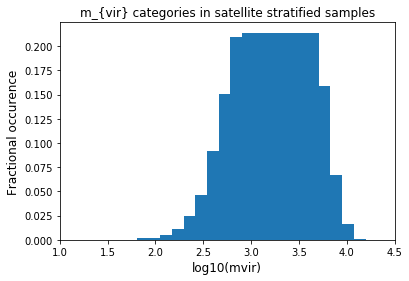

In [193]:
df = halo_combined_final.copy()
#df['log10mvir'] = np.log10(halo_combined_final['mvir'])
#df = df.loc[(df['log10mvir'] <= 3. ) & (df['log10mvir'] >= 2.)]
df = df.loc[(df['Number of Satellites (True)'] == 5 )]
df = index_reset_drop(df)

#bins = np.arange(0,np.max(df['Number of Satellites (True)']),1)
#labels = bins[:-1]
#df['Sats Categories'] = pd.cut(df['Number of Satellites (True)'],
#                               bins = bins, labels=labels,right=False)
N = 50
bins = np.zeros(N+1)
bins[1:] = 10**np.linspace(0,6,N)
labels = np.linspace(0,6,N)
df['Sats Categories'] = pd.cut(df['mvir'],
                               bins = bins, labels=labels,right=True)

with PdfPages('nsats_dist.pdf') as pdf:
    col = df['Sats Categories'].value_counts()
    xvals = np.asarray(col.index.values)
    yvals = np.asarray(col)
    ind = np.argsort(xvals)
    xvals = xvals[ind]
    yvals = yvals[ind]
    plt.bar(xvals, yvals/np.sum(yvals))
    plt.xlabel('log10(mvir)', fontsize=12)
    plt.ylabel('Fractional occurence', fontsize=12)
    plt.title(r'm_{vir} categories in satellite stratified samples', fontsize=12);
    plt.xlim(1,4.5)
    #plt.ylim(0.,0.45)
    pdf.savefig()

## Strategy

Step 1: First _classify_ which halos will have no satellites with m > 1.42.
Define class 0 as those halos that have no satellites, and class 1 as those which have 1 or more satellites.

Step 2: Next, use a _regressor_ to predict the number of satellites halos of class 1 will have.

## Step 1 Training starts here

We'll proceed in 3 steps:

Step 1: Use all halo features to train a random forest classifier. Then plot feature importances to select the top most features.

Step 2: Run the RF classifier with the most important features.

Step 3: Plot a correlation matrix of the most important features, select the least correlated features, and then run the RF classifier.

__Step 1__

In [334]:
halo_features_all =  ['phkey','con','mvir','vmax','a05','a08','vpeak',
'zvpeak','macc','smacc','mergnum','z_firstmerg','z_lastmerg',
'x','y','z','total_spin','g1_25','g2_5','g5','g10','alpha']

# Shuffling
halo_both_sample = halo_both_sample.sample(frac=1).reset_index(drop=True)

y = halo_both_sample['zero or one'].to_numpy()
X = pd.get_dummies(halo_both_sample[halo_features_all])

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state = 0)

rfclass_full = RandomForestClassifier(n_estimators = 300, 
                max_depth = 20.0,min_samples_leaf = 10,
                n_jobs = -1,oob_score = True,random_state = 0,
                max_features='log2')

array([[22809,   245],
       [  668,  1278]])

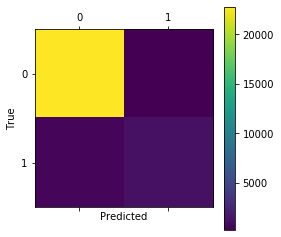

In [336]:
rfclass_full.fit(X_train, y_train);
pred_rfclass_full = rfclass_full.predict(X_val)
cm_full = confusion_matrix(y_val, pred_rfclass_full)
plt.matshow(cm_full)
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('True')
cm_full

In [337]:
def bar_plot(rf, clmns, outfile):
    feature_imp = rf.feature_importances_
    features_arr = np.array(clmns)

    indices = np.argsort(feature_imp)

    with PdfPages(outfile) as pdf:
        fig = plt.figure(figsize=(12,12))
        ax = fig.add_subplot(111)
        plt.subplots_adjust(left = 0.2)
        ax.barh(range(len(indices)), feature_imp[indices])
        ax.set_yticks(range(len(indices)))
        ax.set_yticklabels([features_arr[i] for i in indices])
        pdf.savefig()

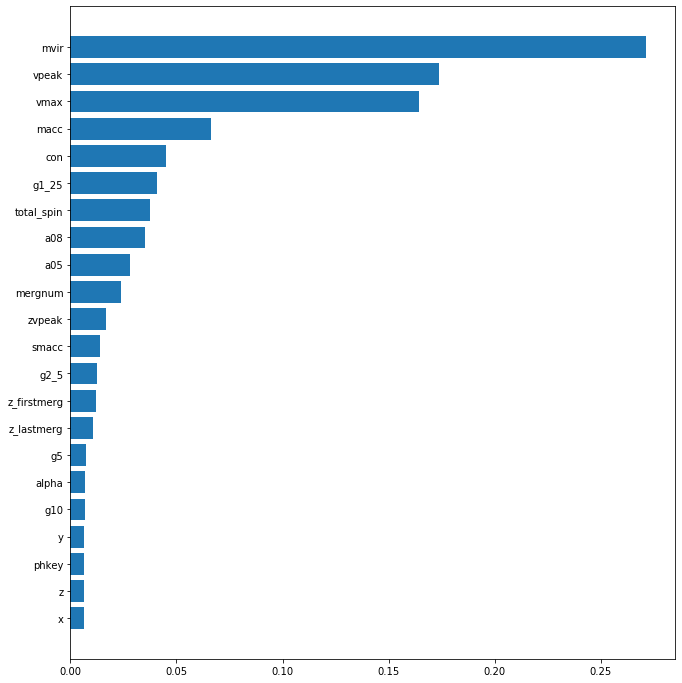

In [338]:
bar_plot(rfclass_full,X_train.columns,'feature_imp_full.pdf')

In [325]:
tn, fp, fn, tp = confusion_matrix(y_val, pred_rfclass_full).ravel()
recall = tp / (tp + fn)
prec = tp / (tp + fp)
accuracy = (tp + tn)/(tp + tn + fp + fn)
print(recall, prec, accuracy)
f1 = 2.0/((1.0/prec) + (1.0/recall))
print(f1)

0.6684607104413348 0.8263473053892215 0.96492
0.7390657542398096


In [326]:
rfclass_full_scores = cross_val_score(rfclass_full, X, y, scoring="f1", cv=5)
print(rfclass_full_scores)
print(np.mean(rfclass_full_scores),np.std(rfclass_full_scores))

[0.73942898 0.73798338 0.74018018 0.73282443 0.74047448]
0.7381782892819928 0.0028123342415645354


__Step 2__

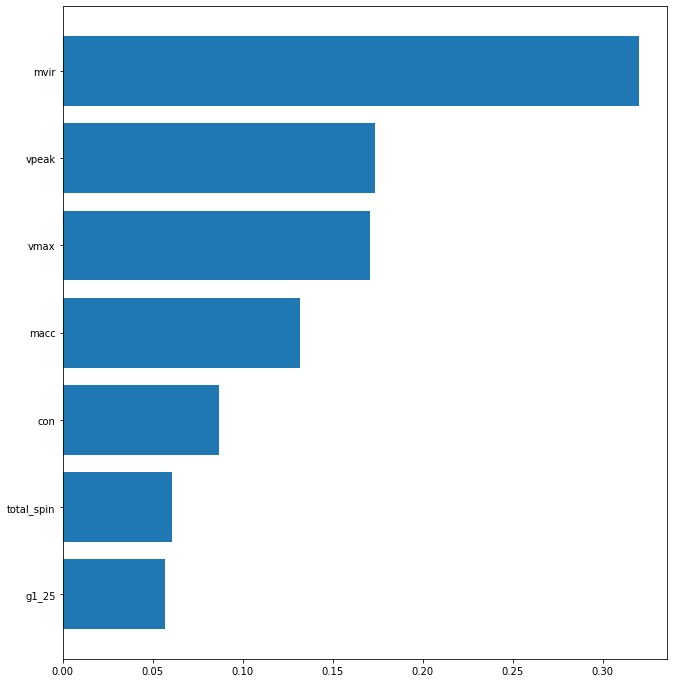

In [339]:
# Using top 7 features
feature_imp = rfclass_full.feature_importances_
features_arr = np.array(X_train.columns)

indices = np.argsort(feature_imp)

feature_pos = np.hstack((indices[-7:-1],indices[-1]))
halo_features_top = features_arr[feature_pos]

X = pd.get_dummies(halo_both_sample[halo_features_top])

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state = 0)
rfclass_top = RandomForestClassifier(n_estimators = 100, 
                max_depth = 20.0,min_samples_leaf = 5,
                n_jobs = -1,oob_score = True,random_state = 0,
                max_features='log2')
rfclass_top.fit(X_train, y_train);
pred_rfclass_top = rfclass_top.predict(X_val)

bar_plot(rfclass_top, X_train.columns, 'feature_imp_top.pdf')

In [340]:
rfclass_top_scores = cross_val_score(rfclass_top, X, y, scoring="f1", cv=5)
print(rfclass_top_scores)
print(np.mean(rfclass_top_scores),np.std(rfclass_top_scores))

[0.73068592 0.72557471 0.7280364  0.72513369 0.72760116]
0.7274063761900645 0.0019854660652186733


In [329]:
def corr_mat(correlation,outfile):
    with PdfPages(outfile) as pdf:
        f, ax_hm = plt.subplots(figsize=(7, 7))
        ax_hm = sns.heatmap(correlation, 
        xticklabels=correlation.columns,
        yticklabels=correlation.columns, annot = True, square = True)
        ax_hm.set_ylim(len(correlation), -0.01)
        pdf.savefig()    

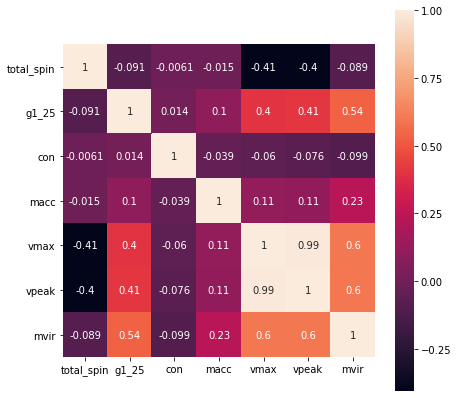

In [341]:
corr_mat(X.corr(),'heatmap_sat_class_red.pdf')

__Step 3__

In [344]:
# Using only uncorrelated features
feature_uncorr_class = ['mvir','vpeak','macc','con',
                        'a08','total_spin']

X = pd.get_dummies(halo_both_sample[feature_uncorr_class])

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state = 0)
rfclass_uncorr = RandomForestClassifier(n_estimators = 100, 
                max_depth = 20.0,min_samples_leaf = 5,
                n_jobs = -1,oob_score = True,random_state = 0,
                max_features='log2')
rfclass_uncorr.fit(X_train, y_train);
pred_rf_uncorr = rfclass_uncorr.predict(X_val)

In [345]:
rfclass_uncorr_scores = cross_val_score(rfclass_uncorr, X, y, scoring="f1", cv=5)
print(rfclass_uncorr_scores)
print(np.mean(rfclass_uncorr_scores),np.std(rfclass_uncorr_scores))

[0.74050179 0.73837416 0.73680556 0.73236441 0.73706897]
0.737022975975153 0.002671309689009511


## Predictions for Step 1

Now making predictions on the entire halo data (~ 1.8 million)

In [346]:
X_full = pd.get_dummies(halo_full[feature_uncorr_class])
pred_full = rfclass_uncorr.predict(X_full)

In [347]:
y_full = halo_full['zero or one']
tn, fp, fn, tp = confusion_matrix(y_full, pred_full).ravel()
recall = tp / (tp + fn)
prec = tp / (tp + fp)
accuracy = (tp + tn)/(tp + tn + fp + fn)
print(recall, prec, accuracy)
f1 = 2.0/((1.0/prec) + (1.0/recall))
print(f1)

0.669763835037011 0.8281555090655509 0.9636365225724218
0.7405854152862766


## Step 2

Now run a regressor to predict number of satellites a halo of class 1 from above will have

In [348]:
# sat_num.to_numpy() gives the values of the 2nd column (# of sats)
# in sat_num

sat_num = sat_data_above['fofID'].value_counts()
sat_num_np = sat_num.to_numpy()

# ground_truth_above contains 2 columns: haloIDs and # of sats

ground_truth_above = pd.DataFrame({'fofID': haloID_above, 
                    'Number of Sats': sat_num_np})

We now have a pd df, _ground_truth_above_, which contains haloIDs and # of sats, arranged in descending order of # of sats. We then need to first pick _haloID_above_ from the central data, and then assign _sat_num_np_ to the halos selected. This is done in two steps:

1) We sort _ground_truth_above_ by fofID.

2) We sort _halo_above_ by fofID. 

In [349]:
ground_truth_above_sort = ground_truth_above.sort_values(by = ['fofID'])
ground_truth_above_sort = index_reset_drop(ground_truth_above_sort)

halo_above_sort = halo_above.sort_values(by = ['fofID'])
halo_above_sort = index_reset_drop(halo_above_sort)

halo_above_sort['Number of Sats'] = ground_truth_above_sort['Number of Sats']

# Shuffle
halo_above_sort = halo_above_sort.sample(frac=1,random_state=0).reset_index(drop=True)

## Step 2 training starts here

In [350]:
y = halo_above_sort['Number of Sats'].to_numpy()
X = pd.get_dummies(halo_above_sort[halo_features_all])
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state = 0)

In [351]:
rfreg_all = RandomForestRegressor(n_estimators = 100, 
                max_depth = 20.0,min_samples_leaf = 5,
                n_jobs = -1,oob_score = True,random_state = 0,
                max_features='log2')
rfreg_all.fit(X_train, y_train);
pred_rfreg_all = rfreg_all.predict(X_val)

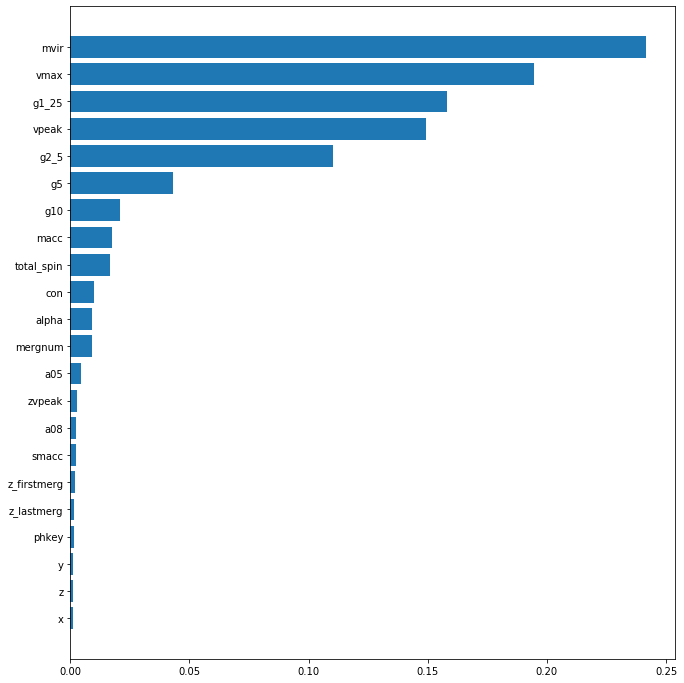

In [352]:
bar_plot(rfreg_all,X_train.columns,'feature_imp_sat_reg_full.pdf')

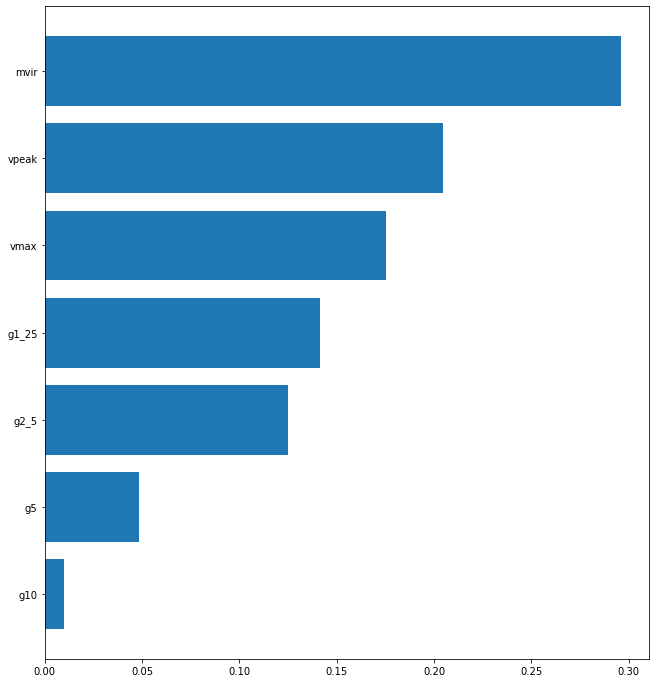

In [353]:
feature_imp = rfreg_all.feature_importances_
features_arr = np.array(X_train.columns)
indices = np.argsort(feature_imp)

feature_pos = np.hstack((indices[-7:-1],indices[-1]))
halo_features_top = features_arr[feature_pos]

X = pd.get_dummies(halo_above_sort[halo_features_top])

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state = 0)
rfreg_top = RandomForestRegressor(n_estimators = 100, 
                max_depth = 20.0,min_samples_leaf = 5,
                n_jobs = -1,oob_score = True,random_state = 0,
                max_features='log2')
rfreg_top.fit(X_train, y_train);
pred_rfreg_top = rfreg_top.predict(X_val)

bar_plot(rfreg_top,X_train.columns,'feature_imp_sat_reg_top.pdf')

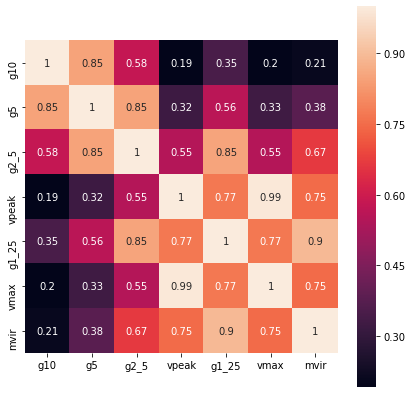

In [354]:
corr_mat(X.corr(),'heatmap_sat_reg_red.pdf')

In [355]:
feature_uncorr_reg = ['mvir','vpeak','g2_5','g5','g10']

X = pd.get_dummies(halo_above_sort[feature_uncorr_reg])

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state = 0)
rfreg_uncorr = RandomForestRegressor(n_estimators = 100, 
                max_depth = 20.0,min_samples_leaf = 5,
                n_jobs = -1,oob_score = True,random_state = 0,
                max_features='log2')
rfreg_uncorr.fit(X_train, y_train);
pred_rf_uncorr = rfreg_uncorr.predict(X_val)

In [356]:
rfreg_uncorr_scores = cross_val_score(rfreg_uncorr, X, y, scoring="r2", cv=5)
print(rfreg_uncorr_scores)
print(np.mean(rfreg_uncorr_scores),np.std(rfreg_uncorr_scores))

[0.93452103 0.93173127 0.93375153 0.89924122 0.91663508]
0.9231760261160918 0.013633793118745262


In [357]:
poly_features = PolynomialFeatures(degree=2, include_bias=True)
X_scale = X.copy()
X_scale[feature_uncorr_reg] = scaler.fit_transform(X_scale[feature_uncorr_reg])
X_poly = poly_features.fit_transform(X_scale)
X_train_poly, X_val_poly, y_train, y_val = train_test_split(X_poly, y, random_state = 0)

ridge_reg = Ridge(alpha=0.01, solver="svd", random_state=0)
ridgereg_scores = cross_val_score(ridge_reg, X_poly, y,
                                scoring="r2", cv=5)
print(ridgereg_scores)
print(np.mean(ridgereg_scores),np.std(ridgereg_scores))

[0.92900913 0.92525613 0.92946349 0.94138205 0.93848777]
0.9327197138460159 0.006138126546016571


In [358]:
print(np.mean(rfreg_uncorr_scores),np.std(rfreg_uncorr_scores))

0.9231760261160918 0.013633793118745262


## Predictions for Step 2

In [359]:
ridge_reg.fit(X_train_poly,y_train)
pred_ridge_reg = ridge_reg.predict(X_poly)
r2_score(pred_ridge_reg,y)

0.9320460487268594

## Setting up predictions for a new data set 

This data set only contains halo properties for which we must predict number of halos   

In [360]:
X_full_cp = cent_data.copy()
X_full = pd.get_dummies(cent_data[feature_uncorr_class])
pred_full = rfclass_uncorr.predict(X_full)
    
X_full_cp['Predicted number of satellites'] = pred_full
X_more = X_full_cp.loc[X_full_cp['Predicted number of satellites'] == 1]
X_none = X_full_cp.loc[X_full_cp['Predicted number of satellites'] == 0]

In [361]:
X_more_reg = pd.get_dummies(X_more[feature_uncorr_reg])
pred_rf_full = rfreg_uncorr.predict(X_more_reg)

In [362]:
X_more_cp = X_more.copy()
X_more_cp['Predicted number of satellites'] = pred_rf_full
X_more = X_more_cp.copy()

X_none_cp = X_none.copy()
X_none_cp['Predicted number of satellites'] = 0
X_none = X_none_cp.copy()

In [363]:
X_full_new = X_none.append(X_more)

In [364]:
X_full_sort = X_full_new.sort_values(by = 'fofID')
X_full_sort = index_reset_drop(X_full_sort)

## Testing regression model on entire satellite data

In [380]:
halo_above_sample2 = halo_above_sort.sample(n=more_num,random_state=0).reset_index(drop=True)
halo_above_sample2 = index_reset_drop(halo_above_sample2)
halo_below_sample2 = halo_below.sample(n=zero_num,random_state=0)
halo_below_sample2 = index_reset_drop(halo_below_sample2)
halo_below_sample2['Number of Sats'] = 0
halo_sample2 = halo_above_sample2.append(halo_below_sample2, ignore_index = True)

halo_sample2 = halo_sample2.sample(frac=1).reset_index(drop=True)
halo_sample2 = index_reset_drop(halo_sample2)

In [383]:
y = halo_sample2['Number of Sats'].to_numpy()
X = pd.get_dummies(halo_sample2[halo_features_all])
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state = 0)

rfreg_2 = RandomForestRegressor(n_estimators = 100, 
                max_depth = 20.0,min_samples_leaf = 5,
                n_jobs = -1,oob_score = True,random_state = 0,
                max_features='log2')
rfreg_2.fit(X_train, y_train);
pred_rfreg_all = rfreg_2.predict(X_val)

In [387]:
rfreg_uncorr_scores_2 = cross_val_score(rfreg_2, X, y, scoring="r2", cv=5)
print(rfreg_uncorr_scores_2)
print(np.mean(rfreg_uncorr_scores_2),np.std(rfreg_uncorr_scores_2))

[0.89881273 0.90141296 0.88945142 0.91353624 0.87460223]
0.8955631129385745 0.012996348539601858


In [388]:
X_above = pd.get_dummies(halo_above_sample2[halo_features_all])
pred_rfreg2_above = rfreg_2.predict(X_above)

In [418]:
haloID_sample2 = halo_sample2['fofID'].unique()
sample2_sort = X_full_sort[X_full_sort['fofID'].isin(haloID_sample2)]
sample2_sort = index_reset_drop(sample2_sort)

In [412]:
halo_sample2_sort = halo_sample2.sort_values(by = 'fofID')
halo_sample2_sort = index_reset_drop(halo_sample2_sort)
X_sample2_sort = pd.get_dummies(halo_sample2_sort[halo_features_all])
pred_rfreg2 = rfreg_2.predict(X_sample2_sort)
pred_rfreg2 = np.rint(pred_rfreg2)

In [428]:
r2_score(pred_rfreg2,halo_sample2_sort['Number of Sats'])

0.9041455162085756

In [436]:
r2_score(sample2_sort['Predicted number of satellites'],
         halo_sample2_sort['Number of Sats'])

0.9085206712998282

## Testing the original Central data set

In [386]:
X_full_sort_above = X_full_sort[X_full_sort['fofID'].isin(haloID_above)]
y_above_true = ground_truth_above_sort['Number of Sats']
y_above_pred = X_full_sort_above['Predicted number of satellites']

r2_score(y_above_pred,y_above_true)

0.9387642587611655

In [271]:
X_full_sort_below = X_full_sort[X_full_sort['fofID'].isin(haloID_below)]
y_below_true = halo_below['zero or one']
y_below_pred = X_full_sort_below['Predicted number of satellites']
y_below_pred = index_reset_drop(y_below_pred)
zero_pred = y_below_pred[y_below_pred['Predicted number of satellites'] == 0.]

#print(zero_pred.shape[0]/y_below_true.shape[0])

0.9881765090141977


array([[22666,   207],
       [  152,  1975]])

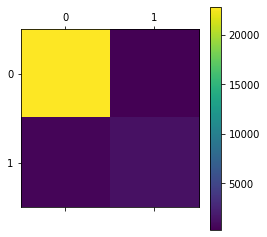

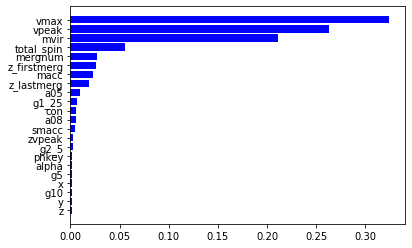

In [47]:
with PdfPages('feature_imp_full.pdf') as export_pdf:
    feature_imp = rfclass_full.feature_importances_
    features_arr = np.array(X_train.columns)

    indices = np.argsort(feature_imp)
    plt.barh(range(len(indices)), feature_imp[indices], color='b', align='center');
    plt.yticks(range(len(indices)), [features_arr[i] for i in indices]);
    export_pdf.savefig()

0.9285378467324871 0.9051329055912007 0.98564
0.9166860060338826


[0.919233   0.91980454 0.92094634 0.91973341 0.91935484]
0.9198144261502879 0.0006061605414067378


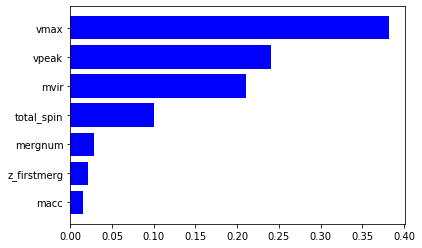

[0.9170076  0.91467969 0.9136939  0.91736735 0.91810842]
0.9161713922740781 0.0016878848665957018


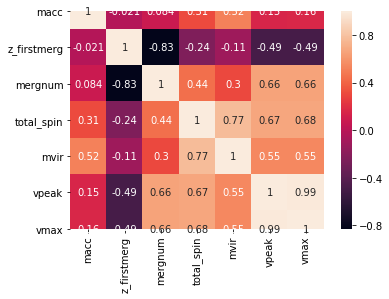

[0.90988626 0.91123919 0.90903857 0.91451753 0.90993072]
0.910922455327456 0.001930344397451475


## Predictions for Central occupancy

In [55]:
X_full = pd.get_dummies(cent_data[feature_uncorr_class])
pred_full = rfclass_uncorr.predict(X_full)

In [56]:
y_full = cent_data_cp['stellarMass']
tn, fp, fn, tp = confusion_matrix(y_full, pred_full).ravel()
recall = tp / (tp + fn)
prec = tp / (tp + fp)
accuracy = (tp + tn)/(tp + tn + fp + fn)
print(recall, prec, accuracy)
f1 = 2.0/((1.0/prec) + (1.0/recall))
print(f1)

0.9229846339663155 0.8921708268148598 0.9839730121730831
0.9073161851037839


In [57]:
cent_data_cp['Predicted Central Occupancy'] = pred_full
cent_data_cp_sort = cent_data_cp.sort_values(by = 'fofID')
cent_data_cp_sort = cent_data_cp_sort.reset_index()
cent_data_cp_sort = cent_data_cp_sort.drop(columns = ['index'])

cent_data_cp_sort['Predicted number of satellites'] = X_full_sort['Predicted number of satellites']


In [58]:
cent_data_sort = cent_data.sort_values(by = 'fofID')
cent_data_sort = cent_data_sort.reset_index()
cent_data_sort = cent_data_sort.drop(columns = ['index'])

cent_data_sort['Predicted number of satellites'] = cent_data_cp_sort['Predicted number of satellites']
cent_data_sort['Predicted Central Occupancy'] = cent_data_cp_sort['Predicted Central Occupancy'] 

## Binning

0.06887649282632247
[[2854    0    0    0]
 [ 102    0    0    0]
 [  11    0    0    0]
 [   1    0    0    0]]


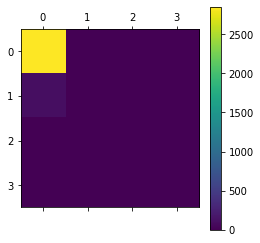

In [295]:
halo_bin_features =  ['phkey','con','mvir','vmax','a05','a08','vpeak',
'zvpeak','macc','smacc','mergnum','z_firstmerg','z_lastmerg',
'x','y','z','type','total_spin','g1_25','g2_5','g5','g10','alpha']
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

#halo_bin_features = ['mvir','vpeak','g2_5','g5']

N = 6
features_arr = np.array(halo_bin_features)
feature_imp = np.zeros((N,features_arr.shape[0]))
indices = np.zeros((N,features_arr.shape[0]))

for j in range(1,2):
    halo_data_bin = halo_cen_unq_sort[(halo_cen_unq_sort['centralMvir'] < 10.**(j+1)) &
                (halo_cen_unq_sort['centralMvir'] > 10.**(j))]
    halo_data_bin = halo_data_bin.reset_index()
    halo_data_bin = halo_data_bin.drop(columns = ['index'])
    halo_ID_bin = halo_data_bin['fofID']

    ground_truth_bin = ground_truth_sort[ground_truth_sort['fofID'].isin(halo_ID_bin)]
    ground_truth_bin = ground_truth_bin.reset_index()
    ground_truth_bin = ground_truth_bin.drop(columns = ['index']) 
                                       
    y_bin = ground_truth_bin['Number of Sats'].to_numpy()
    X_bin = pd.get_dummies(halo_data_bin[halo_bin_features])
                                       
    X_bin_train, X_bin_val, y_bin_train, y_bin_val = train_test_split(X_bin, y_bin, random_state = 0)
#    y_bin_val_arr = np.zeros((N,y_bin_train.shape[0])) 
#    pred_rf_arr = np.zeros_like(y_bin_val)
#    X_bin_val_arr = np.zeros_like(y_bin_val)
#    y_bin_val_arr[j,:] = y_bin_val
#    pred_rf_arr[j,:] = pred_rf
#    X_bin_val_arr[j,:] = X_bin_val
    rfreg_bin = RandomForestRegressor(n_estimators = 100, 
                max_depth = 5.0,min_samples_leaf = 3,
                n_jobs = -1,oob_score = True,random_state = 0,
                max_features='log2')

    rfclass_bin = RandomForestClassifier(n_estimators = 100, 
                max_depth = 5.0,min_samples_leaf = 3,
                n_jobs = -1,oob_score = True,random_state = 0,
                max_features='log2')

    rfreg_bin.fit(X_bin_train, y_bin_train);
    pred_rf = rfreg_bin.predict(X_bin_val)
    print(r2_score(y_bin_val,pred_rf))

    rfclass_bin.fit(X_bin_train, y_bin_train);
    pred_rf = rfclass_bin.predict(X_bin_val)
    cm = confusion_matrix(y_bin_val, pred_rf)
    plt.matshow(cm)
    plt.colorbar()

    print(cm)    
    feature_imp[j,:] = rfreg_bin.feature_importances_

    indices[j,:] = np.argsort(feature_imp[j,:])                     


In [258]:
import collections, numpy

print(collections.Counter(pred_rf), 
      collections.Counter(y_bin_val))

Counter({1: 2968}) Counter({1: 2854, 2: 102, 3: 11, 4: 1})


In [326]:
X_bin_cp = X_bin.copy()
X_bin_cp['num_sat'] = y_bin
X_bin_cp.tail()

,phkey,con,mvir,vmax,a05,a08,vpeak,zvpeak,macc,smacc,...,y,z,type,total_spin,g1_25,g2_5,g5,g10,alpha,num_sat
11865,16762807,0.949853,97.684540,153.26578,0.643761,0.876447,195.39769,0.089288,-261.507308,-2.677059,...,16.663414,472.22916,0,3.392575,8.227546,3.350343,1.166894,0.908859,0.650985,1
11866,16758939,1.116512,49.487762,143.61821,0.463865,0.491220,153.46486,0.623590,-36.412346,-0.735785,...,42.278080,473.09120,0,1.970662,3.749091,3.793927,2.711788,1.705927,0.275349,1
11867,16771808,1.157878,77.459110,172.92862,0.331289,0.764481,203.03825,0.019933,-26.481538,-0.341878,...,25.969719,448.89710,0,3.263480,5.900879,4.619894,2.528303,1.177535,0.384606,1
11868,16752035,1.187418,77.975494,177.73372,0.415625,0.719962,178.04948,0.019933,-46.343308,-0.594332,...,57.536346,441.98224,0,4.586824,2.201721,1.470524,1.160839,1.031394,0.825774,1
11869,16754841,1.031447,55.082030,137.49818,0.519315,0.790902,148.65695,0.242469,-16.551154,-0.300482,...,40.149050,462.37775,0,2.181708,2.124331,2.115950,2.133400,1.283053,0.416986,1


In [327]:
outlier = X_bin_cp.loc[X_bin_cp['num_sat'] != 1]
outlier = outlier.reset_index()
outlier = outlier.drop(columns = ['index'])
outlier['con_new'] = outlier.con

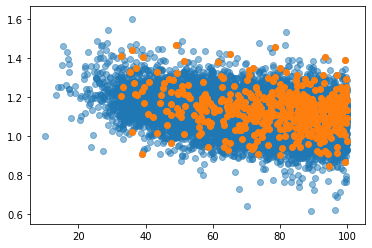

In [328]:
plt.scatter(X_bin.mvir,X_bin.con,alpha=0.5)
plt.scatter(outlier.mvir,outlier.con_new)

In [321]:
X_bin_cp.loc[X_bin_cp['num_sat'] != 1, 'con']= 1.1*(X_bin_cp.con)



In [305]:
X_bin_cp

,phkey,con,mvir,vmax,a05,a08,vpeak,zvpeak,macc,smacc,...,y,z,type,total_spin,g1_25,g2_5,g5,g10,alpha,num_sat
0,5767,1.112402,96.823880,178.96555,0.431211,0.569789,192.94147,1.077875,-92.686154,-0.957265,...,21.525980,37.102856,0,1.291159,4.077098,2.535460,1.190493,0.951082,0.803949,1
1,24109,1.078663,70.832050,156.36598,0.378137,0.778536,167.37381,1.630271,76.135000,1.074867,...,57.445385,40.581707,0,1.796679,14.375061,3.298037,1.633542,1.346350,0.580303,1
2,14246,1.176147,73.844345,172.88109,0.379887,0.562842,181.43068,0.687109,62.894038,0.851711,...,9.290336,24.249660,0,1.948388,2.042845,1.168416,0.927144,0.989585,0.887937,1
3,7080,1.164101,92.262400,184.29446,0.379969,0.649457,208.81897,1.385718,-19.861154,-0.215268,...,22.811821,60.532032,0,0.362541,4.362735,4.172705,1.897275,1.046074,0.320896,1
4,3266,1.263387,80.815670,191.37340,0.406701,0.452867,219.74792,1.173417,62.894231,0.778243,...,22.676504,18.497011,0,0.240367,6.916746,4.510846,2.999653,1.838928,0.301295,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11865,16762807,0.949853,97.684540,153.26578,0.643761,0.876447,195.39769,0.089288,-261.507308,-2.677059,...,16.663414,472.229160,0,3.392575,8.227546,3.350343,1.166894,0.908859,0.650985,1
11866,16758939,1.116512,49.487762,143.61821,0.463865,0.491220,153.46486,0.623590,-36.412346,-0.735785,...,42.278080,473.091200,0,1.970662,3.749091,3.793927,2.711788,1.705927,0.275349,1
11867,16771808,1.157878,77.459110,172.92862,0.331289,0.764481,203.03825,0.019933,-26.481538,-0.341878,...,25.969719,448.897100,0,3.263480,5.900879,4.619894,2.528303,1.177535,0.384606,1
11868,16752035,1.187418,77.975494,177.73372,0.415625,0.719962,178.04948,0.019933,-46.343308,-0.594332,...,57.536346,441.982240,0,4.586824,2.201721,1.470524,1.160839,1.031394,0.825774,1


0.20288540173745706
[[2854    0    0    0]
 [ 102    0    0    0]
 [  11    0    0    0]
 [   1    0    0    0]]


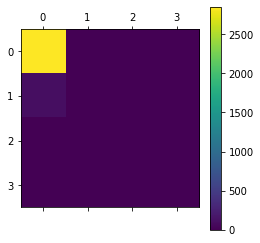

In [322]:
halo_bin_features =  ['phkey','con','mvir','vmax','a05','a08','vpeak',
'zvpeak','macc','smacc','mergnum','z_firstmerg','z_lastmerg',
'x','y','z','type','total_spin','g1_25','g2_5','g5','g10','alpha']

#halo_bin_features = ['mvir','vpeak','g2_5','g5']

N = 6
features_arr = np.array(halo_bin_features)
feature_imp = np.zeros((N,features_arr.shape[0]))
indices = np.zeros((N,features_arr.shape[0]))

for j in range(1,2):                                       
    X_bin_cp1 = pd.get_dummies(X_bin_cp[halo_bin_features])
    X_bin_train, X_bin_val, y_bin_train, y_bin_val = train_test_split(X_bin_cp1, y_bin, random_state = 0)
    rfreg_bin = RandomForestRegressor(n_estimators = 100, 
                max_depth = 5.0,min_samples_leaf = 3,
                n_jobs = -1,oob_score = True,random_state = 0,
                max_features='log2')

    rfclass_bin = RandomForestClassifier(n_estimators = 100, 
                max_depth = 5.0,min_samples_leaf = 3,
                n_jobs = -1,oob_score = True,random_state = 0,
                max_features='log2')

    rfreg_bin.fit(X_bin_train, y_bin_train);
    pred_rf = rfreg_bin.predict(X_bin_val)
    print(r2_score(y_bin_val,pred_rf))

    rfclass_bin.fit(X_bin_train, y_bin_train);
    pred_rf = rfclass_bin.predict(X_bin_val)
    cm = confusion_matrix(y_bin_val, pred_rf)
    plt.matshow(cm)
    plt.colorbar()

    print(cm)    

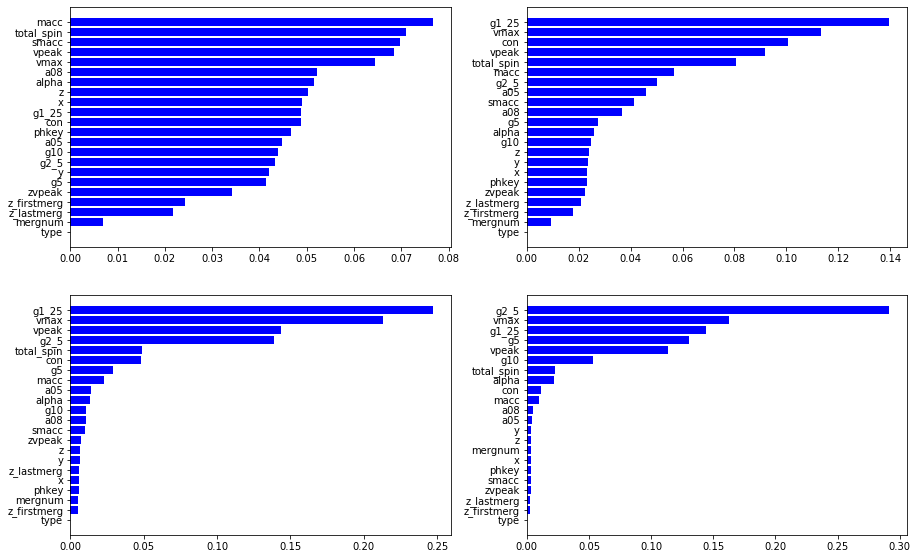